# Setup Environment

In [1]:
from openai import OpenAI
import os
import re
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from numpy import transpose
# Python Implementation of the ROUGE Metric
from rouge_score import rouge_scorer
from gensim.models.keyedvectors import KeyedVectors
from nltk.translate import meteor_score
from statsmodels.stats import inter_rater as irr
import kendall_w as kw
from scipy import stats as statsss
# Resources for METEOR
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
from itertools import combinations
from sklearn.metrics import cohen_kappa_score

# BERTScore leverages the pre-trained contextual embeddings from BERT and matches words in candidate and reference sentences by cosine similarity.
from bert_score import BERTScorer

#client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", ""))


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lorenzozanolin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lorenzozanolin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lorenzozanolin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Automatic Evaluation

First we need to extract the outputs of the various models and the doctor references, used as a base for the comparison.

In [2]:

# rows are actions
# first column GPT4, second GPT4 32k, third GPT4o, fourth Anthropic, fifth is the medician GT

outputs = []  

#save the responses
f = open("Automatic/responses.txt","r")
responses = f.read()

#split in three actions
responses = re.split(r'(Prompt \d+:)',responses)    
responses = [''.join(responses[i:i+2]) for i in range(1, len(responses), 2)]

#cleaning useless lines
for action in range(len(responses)): 
    responses[action] = "\n".join(x for x in responses[action].splitlines() if "Prompt" not in x)
    m_resp = responses[action].split("- ")[1:]  #get all the responses
    outputs.append(m_resp)

outputs_df=pd.DataFrame(outputs)
outputs_df.columns=['GPT4','GPT4 32K','GPT4 Omni', 'Anthropic Claude 3.5 Sonnet','Clinician']
outputs_df=outputs_df.applymap(lambda x : "".join(x.splitlines(True)[1:]))

outputs_df

#useful for plotting
fig= plt.figure()

<Figure size 640x480 with 0 Axes>

## ROUGE score

We will have a dataframe of size $\text{ACTIONS} \times \text{MODELS}$ and for each value we will have a tuple $(\text{F-score rouge1}, \text{F-score rouge2}, \text{F-score rougeL})$

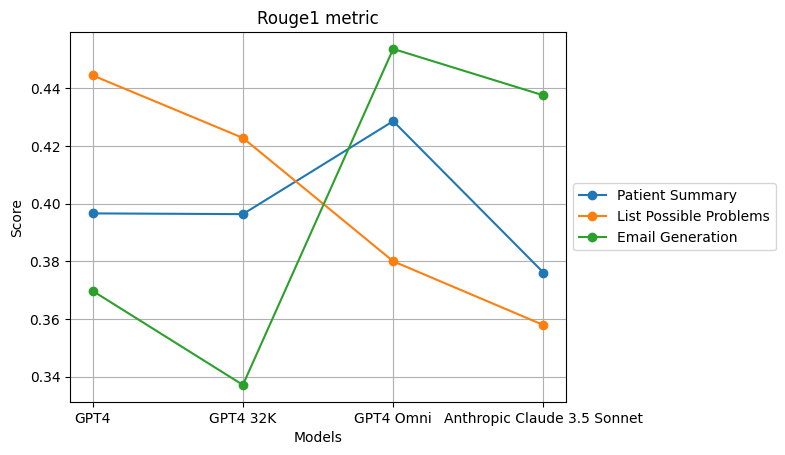

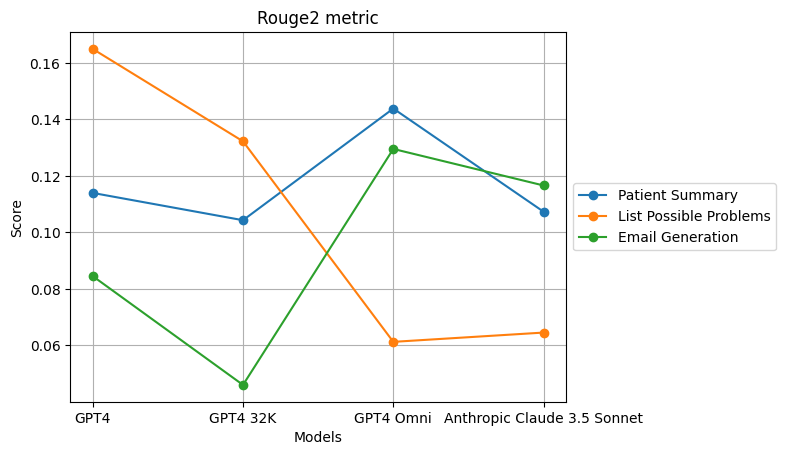

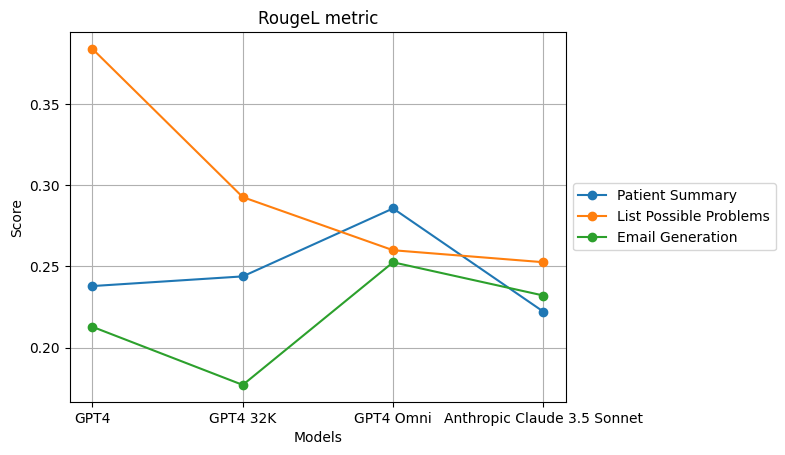

,GPT4,GPT4 32K,GPT4 Omni,Anthropic Claude 3.5 Sonnet
0,"[0.3966005665722379, 0.11396011396011396, 0.23...","[0.3963414634146341, 0.10429447852760736, 0.24...","[0.42857142857142855, 0.14383561643835618, 0.2...","[0.37606837606837606, 0.1072961373390558, 0.22..."
1,"[0.4444444444444444, 0.16494845360824742, 0.38...","[0.4227642276422764, 0.1322314049586777, 0.292...","[0.37999999999999995, 0.06122448979591836, 0.26]","[0.35789473684210527, 0.06451612903225806, 0.2..."
2,"[0.3697478991596639, 0.08450704225352114, 0.21...","[0.3371428571428572, 0.045977011494252866, 0.1...","[0.4536082474226804, 0.1295336787564767, 0.252...","[0.43750000000000006, 0.11659192825112108, 0.2..."


In [3]:
Rscorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

#scores = scorer.score(outputs_df['GPT4'][0], outputs_df['Clinician'][0])

Rmodel_action = pd.DataFrame(np.random.rand(3, 4), columns=outputs_df.columns[:4])   #used for saving for each (action,model) the three fscores
Rmodel_action = Rmodel_action.astype('object') #used to save the list (fscore,fscore,fscore) for each element in the dataframe

for action in range(len(outputs_df)):
    for model in outputs_df.columns[:4]:
        model_metric = []
        for metric in ["rouge1","rouge2","rougeL"]:
            model_metric.append(Rscorer.score(outputs_df[model][action], outputs_df["Clinician"][action])[metric][2]) # 0 for Precision, 1 for Recall, 2 for Fmeasure
            #print(f'{model}: {scorer.score(outputs_df[model][action], outputs_df["Clinician"][action])[metric][2]}') 
            
        Rmodel_action[model][action] = model_metric

num_metrics = 3  # rouge1, rouge2, rougeL
metric_labels = ["Rouge1", "Rouge2", "RougeL"]

for i in range(num_metrics):
    
    # Itera sulle righe del DataFrame e plottare per ciascuna azione
    for action,name in zip(range(len(Rmodel_action)),['Patient Summary','List Possible Problems','Email Generation']):
        # Estrai tutti i valori alla posizione `i` per ciascun modello (colonna) e per l'azione corrente
        values = [Rmodel_action[model][action][i] for model in Rmodel_action.columns]
        plt.plot(Rmodel_action.columns, values, marker='o', label=name)
        
    plt.title(f'{metric_labels[i]} metric')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()
    
Rmodel_action


Now, let's plot each metric.

## BLEU Score

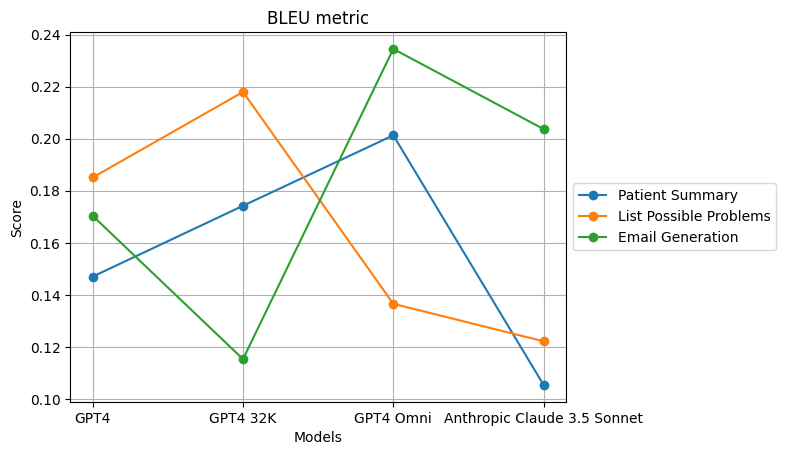

,GPT4,GPT4 32K,GPT4 Omni,Anthropic Claude 3.5 Sonnet
0,0.14701,0.174232,0.20132,0.105376
1,0.18511,0.217977,0.136558,0.122141
2,0.170375,0.115298,0.234521,0.203709


In [4]:

BLmodel_action = pd.DataFrame(np.random.rand(3, 4), columns=outputs_df.columns[:4])   #used for saving for each (action,model) the three fscores
BLmodel_action = Rmodel_action.astype('object') #used to save the list (fscore,fscore,fscore) for each element in the dataframe

for action,name in zip(range(len(outputs_df)),['Patient Summary','List Possible Problems','Email Generation']):
    for model in outputs_df.columns[:4]:
        mscore = nltk.translate.bleu_score.sentence_bleu([nltk.word_tokenize(outputs_df[model][action])], nltk.word_tokenize(outputs_df["Clinician"][action]), weights = (0.5, 0.5))
        
        BLmodel_action[model][action] = mscore #fscore from bertscore
    row = BLmodel_action.iloc[action]
    plt.plot(row.index, row.values, marker='o', label=name)  

#plot results
plt.title('BLEU metric')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Models")
plt.ylabel("Score")
plt.grid(True)
plt.show()
                  

BLmodel_action

## METEOR Score

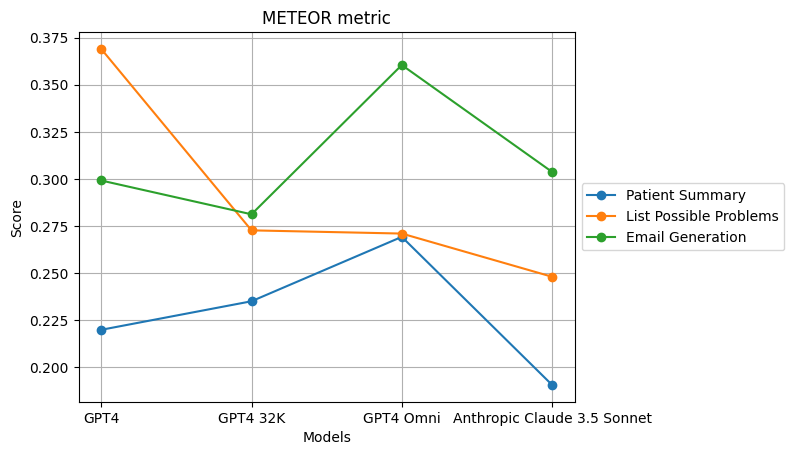

,GPT4,GPT4 32K,GPT4 Omni,Anthropic Claude 3.5 Sonnet
0,0.219767,0.234942,0.269162,0.190481
1,0.369039,0.272621,0.270918,0.247962
2,0.299116,0.281149,0.360483,0.303671


In [5]:

Mmodel_action = pd.DataFrame(np.random.rand(3, 4), columns=outputs_df.columns[:4])   #used for saving for each (action,model) the three fscores
#Mmodel_action = Rmodel_action.astype('object') #used to save the list (fscore,fscore,fscore) for each element in the dataframe

for action,name in zip(range(len(outputs_df)),['Patient Summary','List Possible Problems','Email Generation']):
    for model in outputs_df.columns[:4]:
        mscore = meteor_score.meteor_score([nltk.word_tokenize(outputs_df[model][action])], nltk.word_tokenize(outputs_df["Clinician"][action]))
        #print(f'{outputs_df[model][action]} \n {outputs_df["Clinician"][action]} \n score: {mscore}')     
        Mmodel_action[model][action] = mscore #fscore from bertscore
    row = Mmodel_action.iloc[action]
    plt.plot(row.index, row.values, marker='o', label=name)  

#plot results
plt.title('METEOR metric')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Models")
plt.ylabel("Score")
plt.grid(True)
plt.show()              

Mmodel_action


## Word2Vec

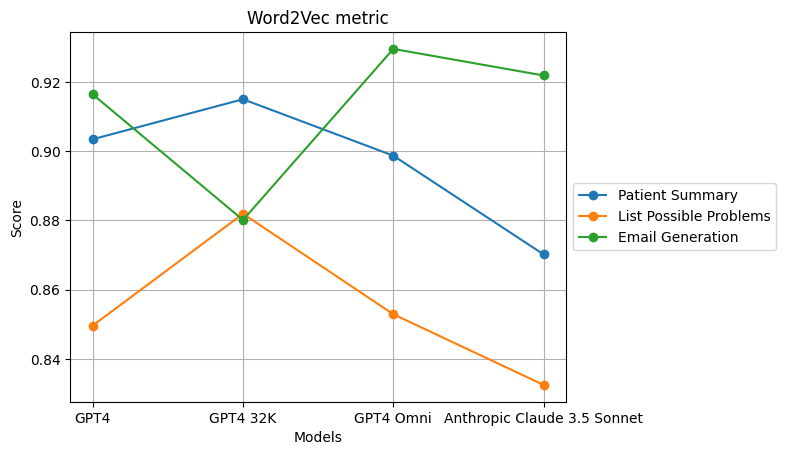

,GPT4,GPT4 32K,GPT4 Omni,Anthropic Claude 3.5 Sonnet
0,0.903455,0.915015,0.898711,0.870182
1,0.84962,0.881928,0.852901,0.832479
2,0.916424,0.88013,0.92955,0.921875


In [6]:

class DocSim:
    def __init__(self, w2v_model, stopwords=None):
        self.w2v_model = w2v_model
        self.stopwords = stopwords if stopwords is not None else []

    def vectorize(self, doc: str) -> np.ndarray:
        """
        Identify the vector values for each word in the given document
        :param doc:
        :return:
        """
        doc = doc.lower()
        words = [w for w in doc.split(" ") if w not in self.stopwords]
        word_vecs = []
        for word in words:
            try:
                vec = self.w2v_model[word]
                word_vecs.append(vec)
            except KeyError:
                # Ignore, if the word doesn't exist in the vocabulary
                pass

        # Assuming that document vector is the mean of all the word vectors
        # PS: There are other & better ways to do it.
        vector = np.mean(word_vecs, axis=0)
        return vector

    def _cosine_sim(self, vecA, vecB):
        """Find the cosine similarity distance between two vectors."""
        csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
        if np.isnan(np.sum(csim)):
            return 0
        return csim

    def calculate_similarity(self, source_doc, target_docs=None, threshold=0):
        """Calculates & returns similarity scores between given source document & all
        the target documents."""
        if not target_docs:
            return []

        if isinstance(target_docs, str):
            target_docs = [target_docs]

        source_vec = self.vectorize(source_doc)
        results = []
        for doc in target_docs:
            target_vec = self.vectorize(doc)
            sim_score = self._cosine_sim(source_vec, target_vec)
            if sim_score > threshold:
                results.append({"score": sim_score, "doc": doc})
            # Sort results by score in desc order
            results.sort(key=lambda k: k["score"], reverse=True)

        return results

model_path = '/Users/lorenzozanolin/Downloads/GoogleNews-vectors-negative300.bin'
w2v_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
ds = DocSim(w2v_model)

Wmodel_action = pd.DataFrame(np.random.rand(3, 4), columns=outputs_df.columns[:4])   #used for saving for each (action,model) the three fscores
Wmodel_action = Rmodel_action.astype('object') #used to save the list (fscore,fscore,fscore) for each element in the dataframe

for action,name in zip(range(len(outputs_df)),['Patient Summary','List Possible Problems','Email Generation']):
    for model in outputs_df.columns[:4]:
        mscore = ds.calculate_similarity(outputs_df[model][action], outputs_df["Clinician"][action])[0]['score']
        #print(f'{outputs_df[model][action]} \n {outputs_df["Clinician"][action]} \n score: {mscore}')     
        Wmodel_action[model][action] = mscore #fscore from bertscore
    row = Wmodel_action.iloc[action]
    plt.plot(row.index, row.values, marker='o', label=name)  

#plot results
plt.title('Word2Vec metric')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Models")
plt.ylabel("Score")
plt.grid(True)
plt.show()                   

Wmodel_action

## BERTScore

BERTScore comes in and leverages the contextual embeddings from the BERT model, aiming to evaluate the similarity between a predicted and a reference sentence in the context of machine-generated text. By comparing embeddings from both sentences, BERTScore captures semantic similarities that might be missed by traditional n-gram based metrics (ex. ROUGE).

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


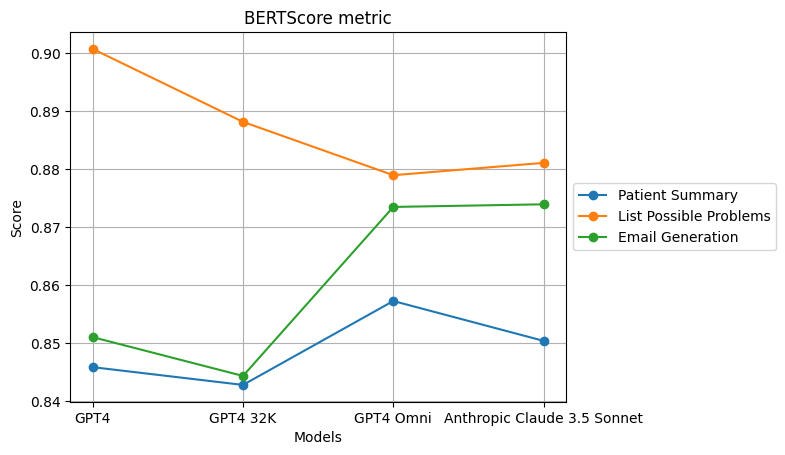

,GPT4,GPT4 32K,GPT4 Omni,Anthropic Claude 3.5 Sonnet
0,0.845834,0.842772,0.857235,0.850365
1,0.900683,0.888112,0.878917,0.881043
2,0.851005,0.844319,0.87345,0.873901


In [7]:

Bscorer = BERTScorer(lang="en")

Bmodel_action = pd.DataFrame(np.random.rand(3, 4), columns=outputs_df.columns[:4])   #used for saving for each (action,model) the three fscores
Bmodel_action = Bmodel_action.astype('object') #used to save the scores
for action,name in zip(range(len(outputs_df)),['Patient Summary','List Possible Problems','Email Generation']):
    for model in outputs_df.columns[:4]:
        _,_,fscore = Bscorer.score([outputs_df[model][action]], [outputs_df["Clinician"][action]])
        #print(f'{outputs_df[model][action]} \n {outputs_df["Clinician"][action]} \n score: {fscore}')     
        Bmodel_action[model][action] = fscore.tolist()[0] #fscore from bertscore
    row = Bmodel_action.iloc[action]
    plt.plot(row.index, row.values, marker='o', label=name)  

#plot results
plt.title('BERTScore metric')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Models")
plt.ylabel("Score")
plt.grid(True)
plt.show()      
                  
Bmodel_action

## G-Eval

We will now use ChatGPT to evaluate the texts under various criteria:

- *Accuracy*: How accurate is the information you read compared to the doctor's notes?
- *Relevance*: How relevant is the answer to the question's request? Is it in line with the doctor's?
- *Coverage*: Does the answer provided cover all the required points? Are all the informations that were in the doctor's notes included?
- *Clarity*: Is the quality of the answer (in terms of syntax and form) correct? Do you notice any imperfections?
- *Satisfaction*: Are you satisfied with the answer? Would you be able to accept it as an answer in place of a note written by a doctor?


But since we have no budget :D, we will ask manually to ChatGPT...

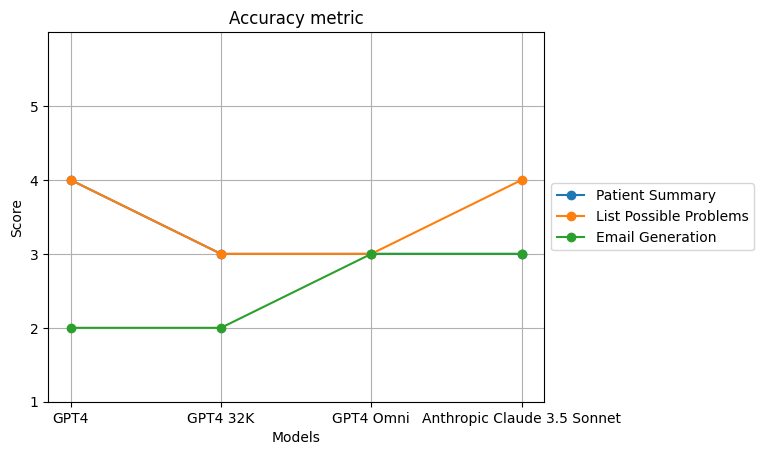

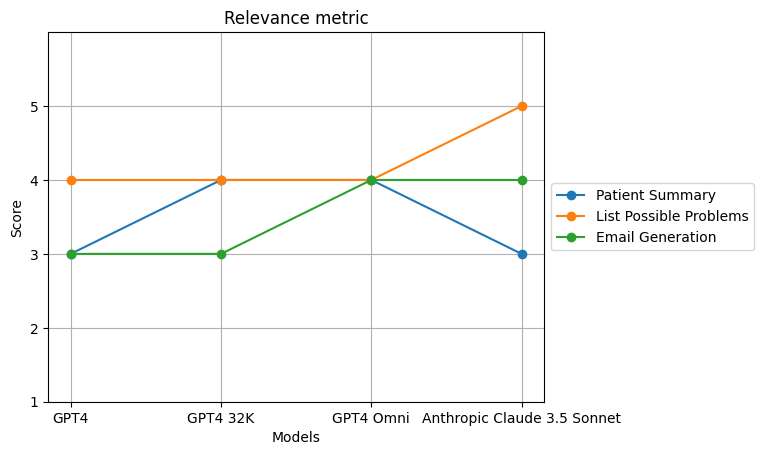

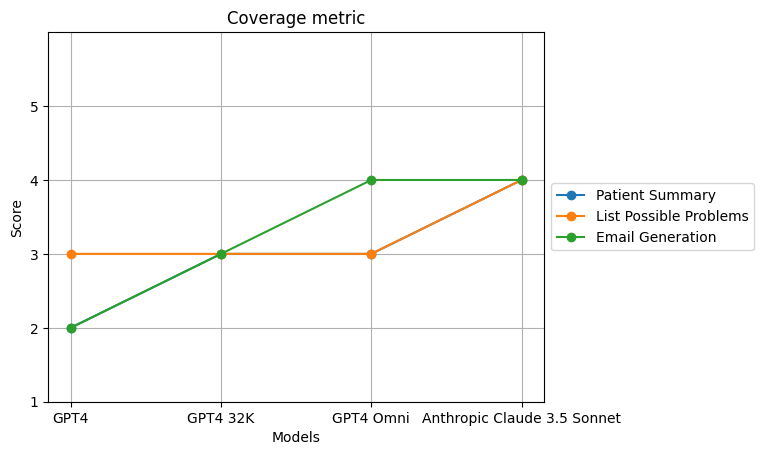

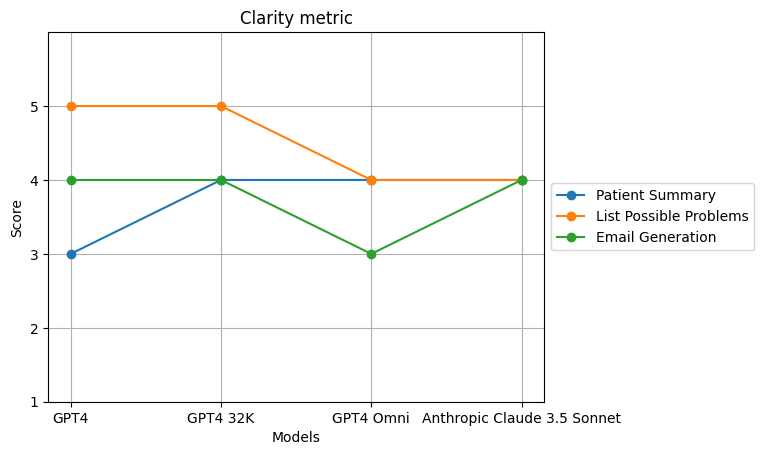

,GPT4,GPT4 32K,GPT4 Omni,Anthropic Claude 3.5 Sonnet
0,"[4, 3, 2, 3]","[3, 4, 3, 4]","[3, 4, 3, 4]","[3, 3, 4, 4]"
1,"[4, 4, 3, 5]","[3, 4, 3, 5]","[3, 4, 3, 4]","[4, 5, 4, 4]"
2,"[2, 3, 2, 4]","[2, 3, 3, 4]","[3, 4, 4, 3]","[3, 4, 4, 4]"


In [8]:

Gmodel_action = pd.DataFrame(np.random.rand(3, 4), columns=outputs_df.columns[:4])   #used for saving for each (action,model) the three fscores
Gmodel_action = Gmodel_action.astype('object') #used to save the scores, [Accuracy, Relevance, Coverage, Clarity]

example_prompt= '''
You will be given one summary written from a model. Your task is to rate the summary on one metric using as a reference a handwritten text from the doctor.
Please make sure you read and understand these instructions very carefully. 
Please keep this document open while reviewing, and refer to it as needed.

Evaluation Criteria:

Accuracy(1-5) - How accurate is the information you read compared to the doctor's notes?"

Relevance(1-5) - selection of important content from the source. \
The summary should include only important information from the source document. \
Annotators were instructed to penalize summaries which contained redundancies and excess information.

Coverage(1-5) - Does the answer provided cover all the required points? Are all the informations that were in the doctor's notes included?

Clarity(1-5): the quality of the summary in terms of grammar, spelling, punctuation, word choice, and sentence structure.
1: Poor. The summary has many errors that make it hard to understand or sound unnatural.
2: Fair. The summary has some errors that affect the clarity or smoothness of the text, but the main points are still comprehensible.
3: OK. The summary has few errors and is easy to read and follow.
4: Good. The summary has no errors and is easy to read and follow, but can be better; maybe it can be written in a more natural way.
5: Perfect. The summary has no errors and seems to be written from a human.


Evaluation Steps:

Accuracy: 
1. Read the text from the doctor carefully and identify the main topic and key points.
2. Read the summary of the model and compare it to the text from the doctor. Check if the summary covers the main topic and key points of the article,
and if it presents them in a clear and logical order.
3. Assign a score for accuracy on a scale of 1 to 5, where 1 is the lowest and 5 is the highest based on the Evaluation Criteria.
"""

Relevance:
"""
1. Read the summary and the source document carefully.
2. Compare the summary to the source document and identify the main points of the article.
3. Assess how well the summary covers the main points of the article, and how much irrelevant or redundant information it contains.
4. Assign a relevance score from 1 to 5.
"""

Coverage:
"""
1. Read the article carefully and identify the main facts and details it presents.
2. Read the summary and compare it to the article. Check if the summary contains all the main informations that were in the doctor's notes.
3. Assign a score for coverage based on the Evaluation Criteria.
"""

Clarity:
"""
Read the summary and evaluate its fluency based on the given criteria. Assign a fluency score from 1 to 5.
"""

Test:

Handwritten Text from the Doctor:
""
Patient Zanolin Lorenzo is a 23-year-old male, born on 10/20/2000 and legally recognized by the cf ZNLLNZ00R20G888E. He currently resides in Strada Mus in Polcenigo (Pordenone, 33070); other information on his contact is email: l.zanolin@reply.it and mobile: +393427234343. His weight is 66kg.

He currently has the following health conditions: he was diagnosed with Chron's disease on 7/17/2024 by Doctor Andrea Bianchi. During that visit, his Oxygen saturation level (SpO2) was measured, obtaining an average value of 97. The treatment prescribed was Cortisone, with a daily dose of 33mg/day.
The same day, he was diagnosed with Obstructive Sleep Apnea, again during the same visit, by Doctor Bianchi. The prescribed treatment was Tachifludec with 132mg/day.

The patient has a lactose allergy, which must be taken into account both in the analysis of symptoms and in the prescription of drugs (which may contain it).
""

Summary written from the model:


Evaluation Form (GIVE EXPLANATION ON WHY YOU GIVE A SCORE):

'''

# Summarization
Gmodel_action['GPT4'][0] = [4,3,2,3]
Gmodel_action['GPT4 32K'][0] = [3,4,3,4]
Gmodel_action['GPT4 Omni'][0] = [3,4,3,4]
Gmodel_action['Anthropic Claude 3.5 Sonnet'][0] = [3,3,4,4]

# Medications suggestion
Gmodel_action['GPT4'][1] = [4,4,3,5]
Gmodel_action['GPT4 32K'][1] = [3,4,3,5]
Gmodel_action['GPT4 Omni'][1] = [3,4,3,4]
Gmodel_action['Anthropic Claude 3.5 Sonnet'][1] = [4,5,4,4]

# Email generation
Gmodel_action['GPT4'][2] = [2,3,2,4]
Gmodel_action['GPT4 32K'][2] = [2,3,3,4]
Gmodel_action['GPT4 Omni'][2] = [3,4,4,3]
Gmodel_action['Anthropic Claude 3.5 Sonnet'][2] = [3,4,4,4]

num_metrics = 4
Gmetric_labels = ["Accuracy", "Relevance", "Coverage","Clarity"]

for i in range(num_metrics):
    
    # Itera sulle righe del DataFrame e plottare per ciascuna azione
    for action,name in zip(range(len(Gmodel_action)),['Patient Summary','List Possible Problems','Email Generation']):
        # Estrai tutti i valori alla posizione `i` per ciascun modello (colonna) e per l'azione corrente
        values = [Gmodel_action[model][action][i] for model in Gmodel_action.columns]
        plt.plot(Gmodel_action.columns, values, marker='o', label=name)
    
    plt.title(f'{Gmetric_labels[i]} metric')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Models')
    plt.ylim((1, 6))
    plt.yticks(range(1, 6, 1))
    
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

Gmodel_action

# Human Evaluation

We need to import the CSV file into a dataframe to then do the statistical analysis.

In [9]:
human_eval = pd.read_csv(r"Human Feedback/humanEval.csv", sep=',').drop(columns=['Informazioni cronologiche'])

human_eval = human_eval.applymap(lambda x : 5 if (isinstance(x, str) and '5' in x) else x)  #remove textual descriptions
human_eval = human_eval.applymap(lambda x : 1 if (isinstance(x, str) and '1' in x) else x)  #remove textual descriptions

human_eval = human_eval.astype('int')
human_eval

,Evalutation GPT4 (Patient Summary) [Accuracy],Evalutation GPT4 (Patient Summary) [Relevance],Evalutation GPT4 (Patient Summary) [Coverage],Evalutation GPT4 (Patient Summary) [Clarity],Evalutation GPT4 (Patient Summary) [Satisfaction],Evalutation GPT4 32K (Patient Summary) [Accuracy],Evalutation GPT4 32K (Patient Summary) [Relevance],Evalutation GPT4 32K (Patient Summary) [Coverage],Evalutation GPT4 32K (Patient Summary) [Clarity],Evalutation GPT4 32K (Patient Summary) [Satisfaction],...,Evalutation GPT4 Omni (Email Generation) [Accuracy],Evalutation GPT4 Omni (Email Generation) [Relevance],Evalutation GPT4 Omni (Email Generation) [Coverage],Evalutation GPT4 Omni (Email Generation) [Clarity],Evalutation GPT4 Omni (Email Generation) [Satisfaction],Evalutation Anthropic Claude 3.5 Sonnet (Email Generation) [Accuracy],Evalutation Anthropic Claude 3.5 Sonnet (Email Generation) [Relevance],Evalutation Anthropic Claude 3.5 Sonnet (Email Generation) [Coverage],Evalutation Anthropic Claude 3.5 Sonnet (Email Generation) [Clarity],Evalutation Anthropic Claude 3.5 Sonnet (Email Generation) [Satisfaction]
0,4,5,3,4,5,4,5,3,4,5,...,3,4,3,3,3,3,4,3,3,3
1,4,4,3,3,4,4,4,3,4,4,...,4,4,4,4,4,4,3,4,5,4
2,4,4,4,4,4,4,4,4,4,4,...,4,4,4,5,5,3,4,3,3,3
3,3,4,3,4,5,4,5,4,4,5,...,4,4,4,5,5,4,4,4,5,5
4,3,4,3,3,4,3,3,4,3,4,...,3,3,3,3,2,3,3,3,3,3
5,3,4,3,4,3,3,3,4,4,4,...,4,4,4,4,4,5,4,5,5,4
6,4,4,4,4,4,4,4,5,4,5,...,4,5,5,4,4,4,4,4,5,5
7,4,4,2,5,3,4,4,2,5,2,...,4,4,4,4,4,5,5,5,5,5
8,4,3,3,4,4,4,4,4,4,4,...,5,4,4,4,4,5,5,4,5,4
9,4,4,4,4,3,4,4,4,4,4,...,4,4,4,4,4,4,4,3,4,4


Now, let's compact the results and create a single table containing the metrics for each $(\text{Action, Model})$

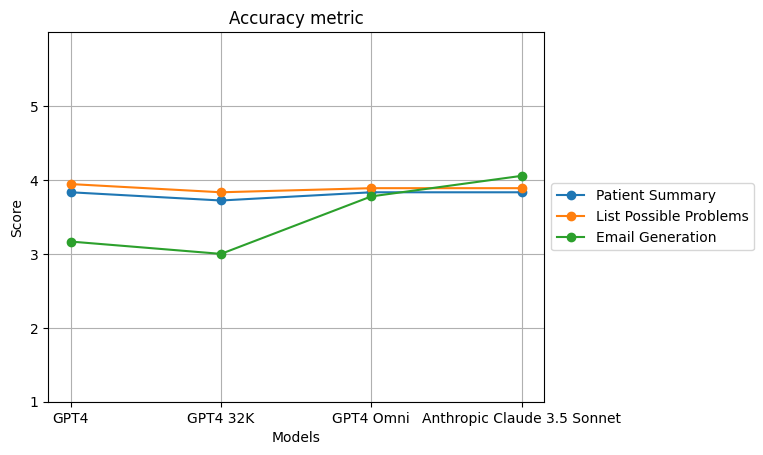

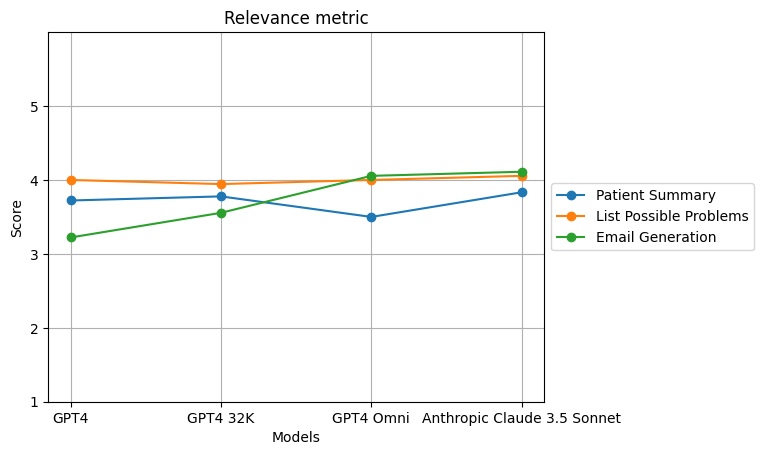

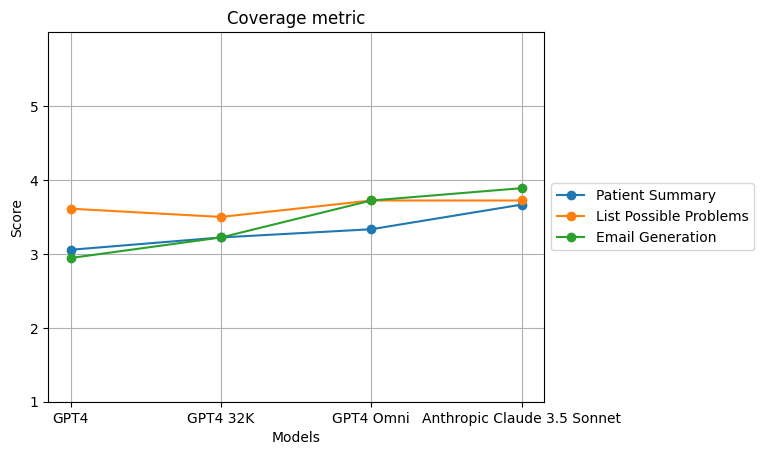

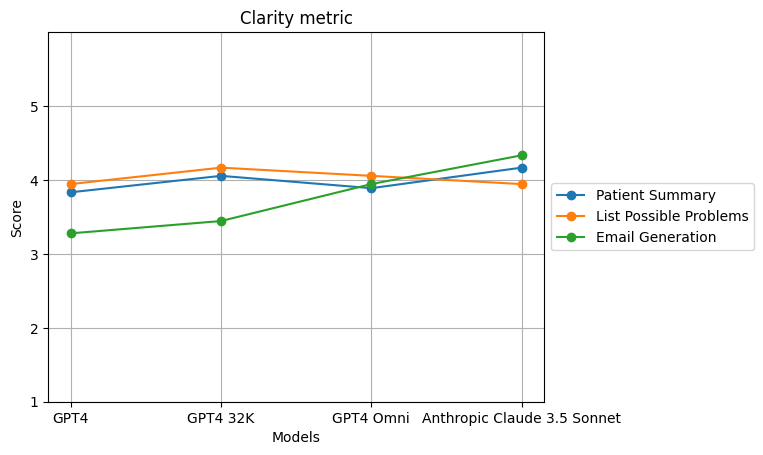

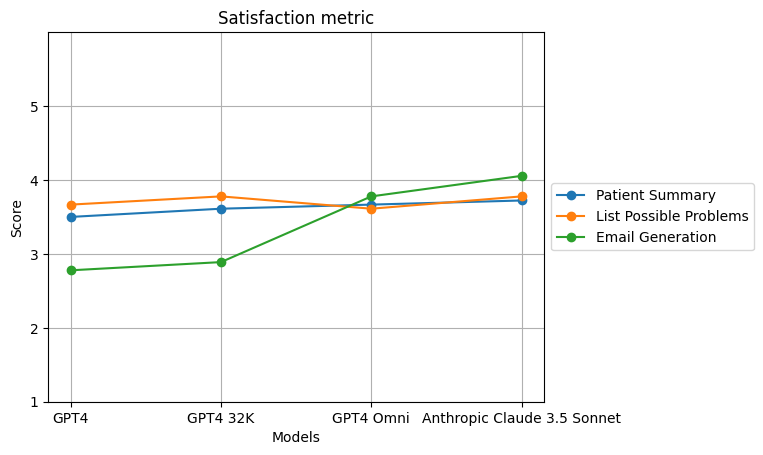

,GPT4,GPT4 32K,GPT4 Omni,Anthropic Claude 3.5 Sonnet
0,"[3.8333333333333335, 3.7222222222222223, 3.055...","[3.7222222222222223, 3.7777777777777777, 3.222...","[3.8333333333333335, 3.5, 3.3333333333333335, ...","[3.8333333333333335, 3.8333333333333335, 3.666..."
1,"[3.9444444444444446, 4.0, 3.611111111111111, 3...","[3.8333333333333335, 3.9444444444444446, 3.5, ...","[3.888888888888889, 4.0, 3.7222222222222223, 4...","[3.888888888888889, 4.055555555555555, 3.72222..."
2,"[3.1666666666666665, 3.2222222222222223, 2.944...","[3.0, 3.5555555555555554, 3.2222222222222223, ...","[3.7777777777777777, 4.055555555555555, 3.7222...","[4.055555555555555, 4.111111111111111, 3.88888..."


In [10]:
human_eval_compact = pd.DataFrame(np.random.rand(3, 4), columns=outputs_df.columns[:4]) 
human_eval_compact = human_eval_compact.astype('object')
#Evalutation GPT4 (Patient Summary) [Accuracy]
for model in ['GPT4','GPT4 32K','GPT4 Omni', 'Anthropic Claude 3.5 Sonnet']:
    for action,i in zip([' (Patient Summary)',' (Medications Suggest)',' (Email Generation)'],range(3)):
        values = []
        for metric in [' [Accuracy]',' [Relevance]',' [Coverage]',' [Clarity]',' [Satisfaction]']:
            mean_col = pd.to_numeric(human_eval['Evalutation '+model+action+metric]).mean()
            values.append(mean_col)
        human_eval_compact[model][i] = values
    
num_metrics = 5
Hmetric_labels = ["Accuracy", "Relevance", "Coverage","Clarity","Satisfaction"]

for i in range(num_metrics):
    
    # Itera sulle righe del DataFrame e plottare per ciascuna azione
    for action,name in zip(range(len(human_eval_compact)),['Patient Summary','List Possible Problems','Email Generation']):
        # Estrai tutti i valori alla posizione `i` per ciascun modello (colonna) e per l'azione corrente
        values = [human_eval_compact[model][action][i] for model in human_eval_compact.columns]
        plt.plot(human_eval_compact.columns, values, marker='o', label=name)
    
    plt.title(f'{Hmetric_labels[i]} metric')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Models')
    plt.ylim((1, 6))
    plt.yticks(range(1, 6, 1))
    
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()    

human_eval_compact.head()

Let's also plot the comparision between GEval and Human Evaluation values.

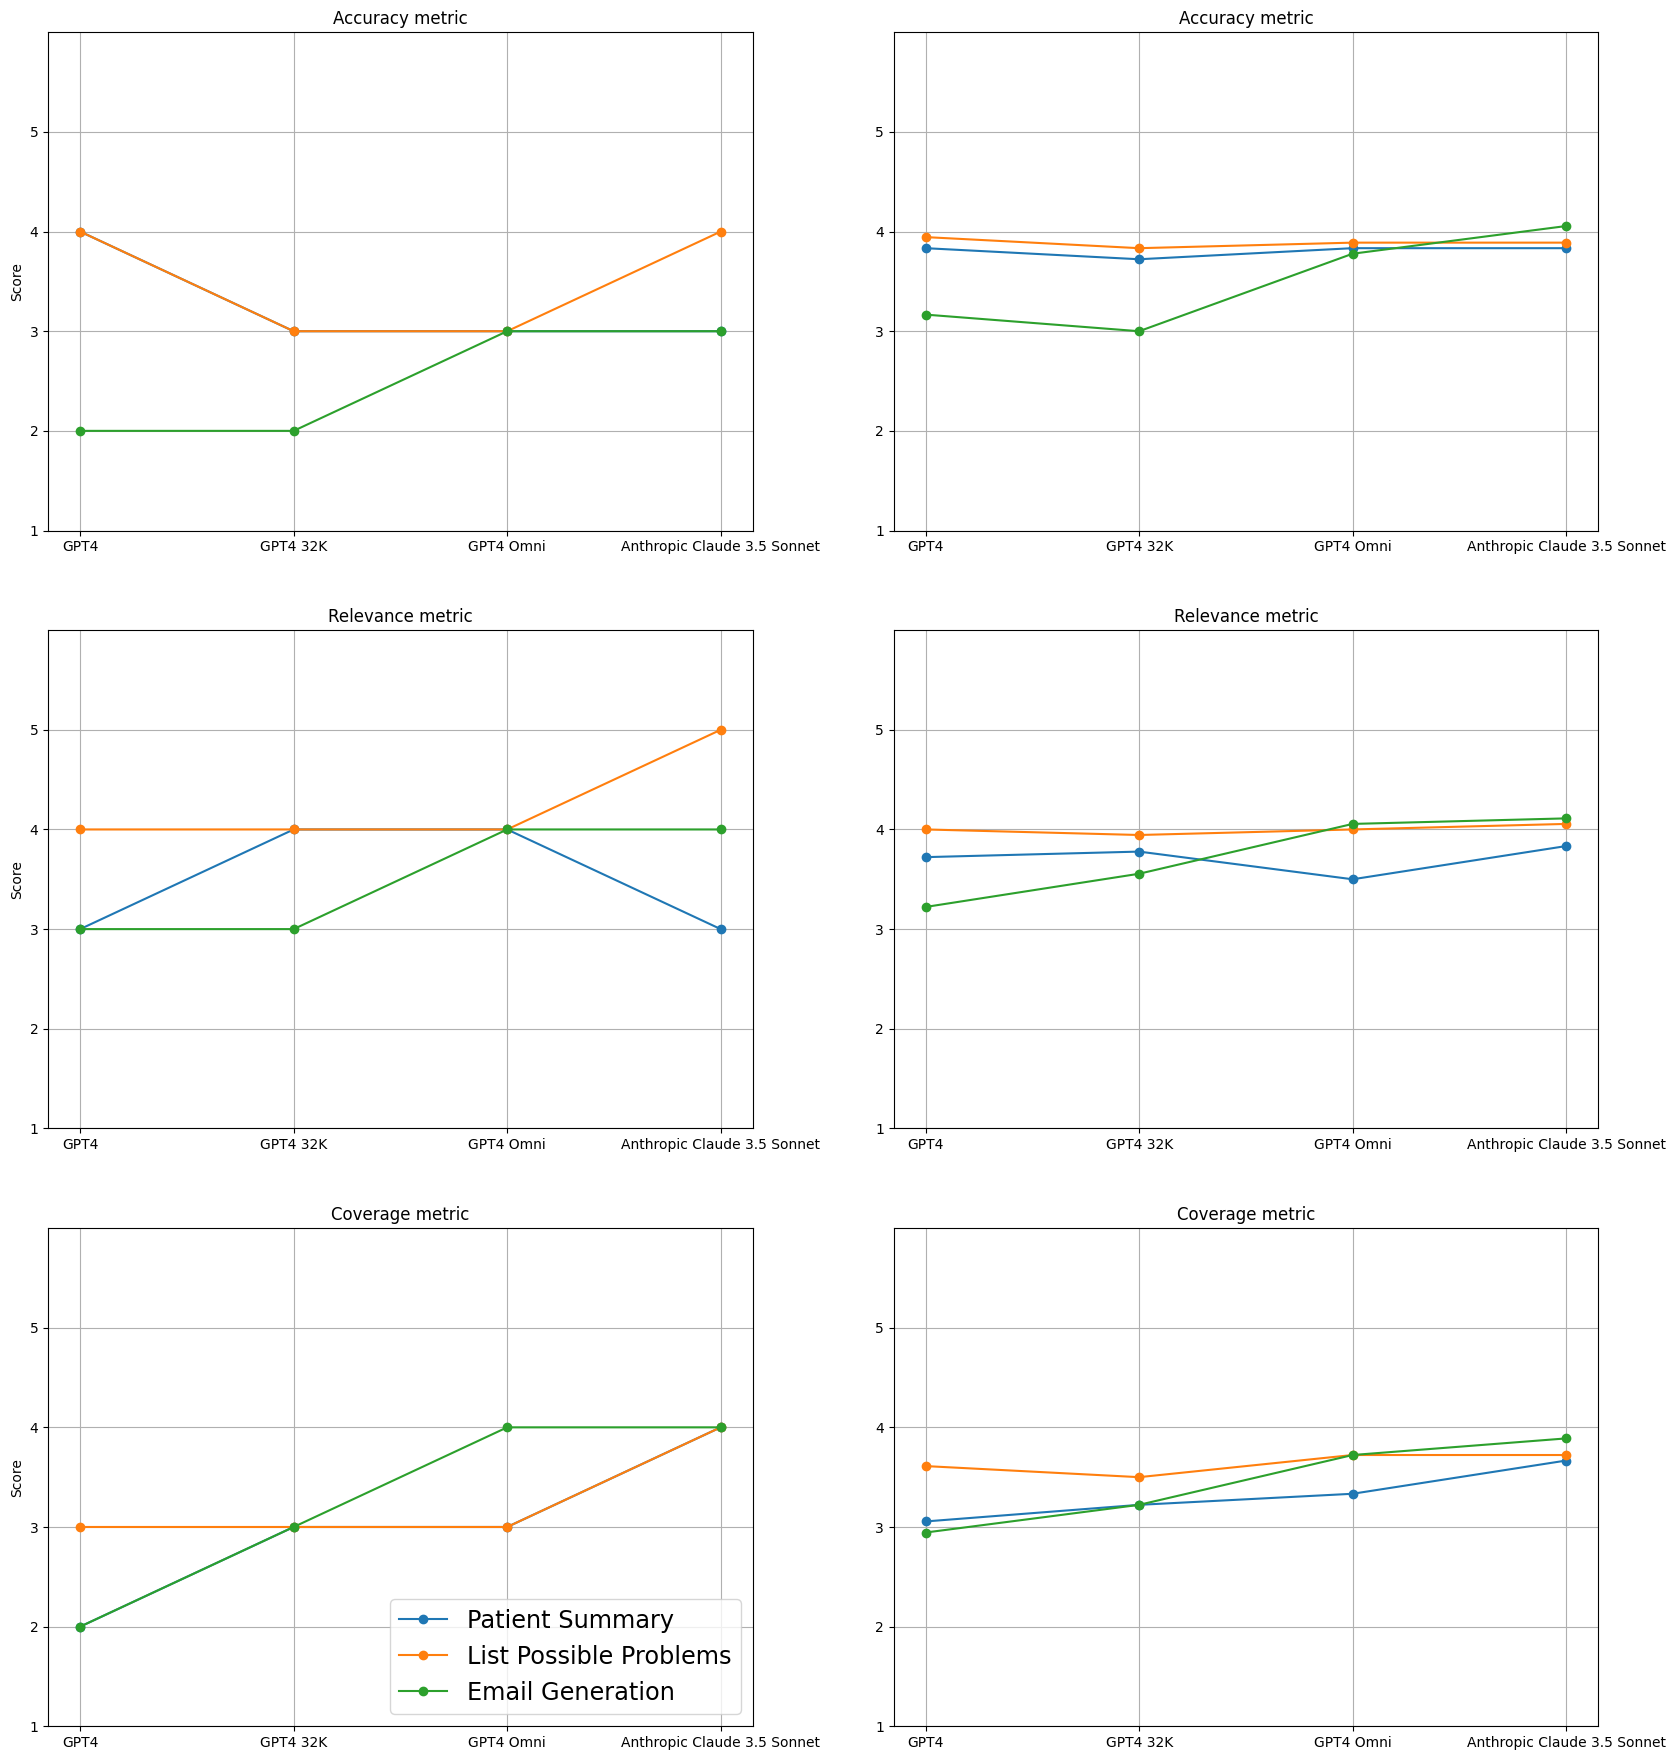

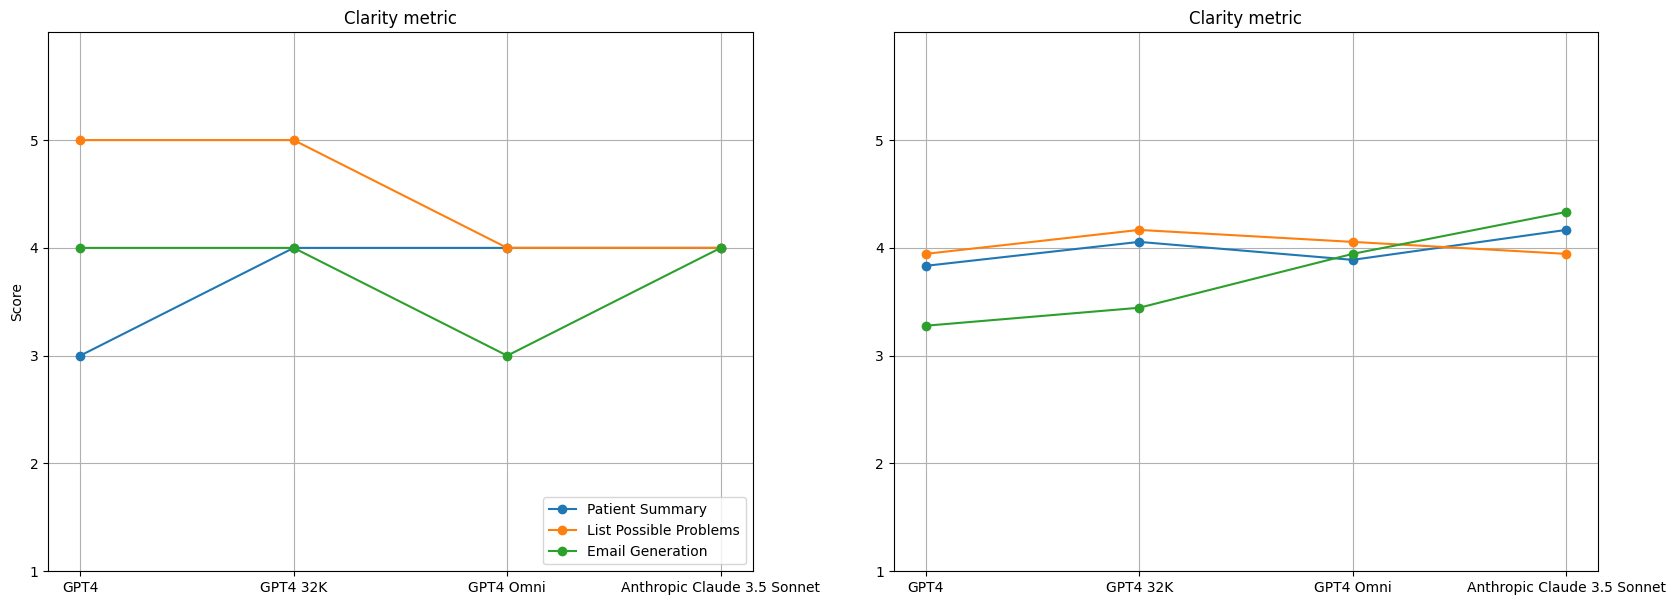

In [11]:
fig, axs = plt.subplots(3, 2)  # 3 righe, 2 colonne

for metric in range(3):
    gx = axs[metric,0]  # posiziona il subplot nelle righe e colonne giuste
    hx = axs[metric,1]  # posiziona il subplot nelle righe e colonne giuste
    for action,label in zip(range(len(Gmodel_action)),['Patient Summary', 'List Possible Problems', 'Email Generation']):
        Gvalues = [Gmodel_action[model][action][metric] for model in Gmodel_action.columns]
        Hvalues = [human_eval_compact[model][action][metric] for model in Gmodel_action.columns]
        gx.plot(Gmodel_action.columns, Gvalues, marker='o', label=label)
        hx.plot(Gmodel_action.columns, Hvalues, marker='o', label=label)
    gx.set_title(f'{Gmetric_labels[metric]} metric')
    hx.set_title(f'{Gmetric_labels[metric]} metric')
    gx.set_ylabel('Score')
    gx.set_ylim((1, 6))
    hx.set_ylim((1, 6))
    gx.set_yticks(range(1, 6, 1))
    hx.set_yticks(range(1, 6, 1))
    gx.grid(True)
    hx.grid(True)
    if metric ==2:
        gx.legend(loc='lower right',fontsize='xx-large')


fig.set_size_inches(20,22)

fig, axs = plt.subplots(1, 2)  # 1 righe, 2 colonne

gx = axs[0]  # posiziona il subplot nelle righe e colonne giuste
hx = axs[1]  # posiziona il subplot nelle righe e colonne giuste
for action,label in zip(range(len(Gmodel_action)),['Patient Summary', 'List Possible Problems', 'Email Generation']):
    Gvalues = [Gmodel_action[model][action][3] for model in Gmodel_action.columns]
    Hvalues = [human_eval_compact[model][action][3] for model in Gmodel_action.columns]
    gx.plot(Gmodel_action.columns, Gvalues, marker='o', label=label)
    hx.plot(Gmodel_action.columns, Hvalues, marker='o', label=label)
gx.set_title(f'{Gmetric_labels[3]} metric')
hx.set_title(f'{Gmetric_labels[3]} metric')
gx.set_ylabel('Score')
gx.set_ylim((1, 6))
hx.set_ylim((1, 6))
gx.set_yticks(range(1, 6, 1))
hx.set_yticks(range(1, 6, 1))
gx.grid(True)
hx.grid(True)
gx.legend(loc='lower right',fontsize='medium')

fig.set_size_inches(20,7)
    

In [12]:
Gmodel_action
human_eval_compact

,GPT4,GPT4 32K,GPT4 Omni,Anthropic Claude 3.5 Sonnet
0,"[3.8333333333333335, 3.7222222222222223, 3.055...","[3.7222222222222223, 3.7777777777777777, 3.222...","[3.8333333333333335, 3.5, 3.3333333333333335, ...","[3.8333333333333335, 3.8333333333333335, 3.666..."
1,"[3.9444444444444446, 4.0, 3.611111111111111, 3...","[3.8333333333333335, 3.9444444444444446, 3.5, ...","[3.888888888888889, 4.0, 3.7222222222222223, 4...","[3.888888888888889, 4.055555555555555, 3.72222..."
2,"[3.1666666666666665, 3.2222222222222223, 2.944...","[3.0, 3.5555555555555554, 3.2222222222222223, ...","[3.7777777777777777, 4.055555555555555, 3.7222...","[4.055555555555555, 4.111111111111111, 3.88888..."


## Statistical analysis

We will now proceed to calculate 
- *std deviation* for each tuple $(\text{Task}, \text{Model}, \text{Metric})$ to check the distribuition of the grades 
- *Weighted Cohen's kappa* for the agreement within the group of Votants: firstly for $(\text{Task},\text{Metric})$ then for $(\text{Task},\text{Model})$
- *Spearman’s correlation* between GEval and Human Feedback

### Std deviation

In [13]:
std_vals = pd.DataFrame(data=[human_eval[column].std() for column in human_eval.columns if 'Satisfaction' not in column]).transpose()
std_vals.columns = [column for column in human_eval.columns if 'Satisfaction' not in column]
std_vals

,Evalutation GPT4 (Patient Summary) [Accuracy],Evalutation GPT4 (Patient Summary) [Relevance],Evalutation GPT4 (Patient Summary) [Coverage],Evalutation GPT4 (Patient Summary) [Clarity],Evalutation GPT4 32K (Patient Summary) [Accuracy],Evalutation GPT4 32K (Patient Summary) [Relevance],Evalutation GPT4 32K (Patient Summary) [Coverage],Evalutation GPT4 32K (Patient Summary) [Clarity],Evalutation GPT4 Omni (Patient Summary) [Accuracy],Evalutation GPT4 Omni (Patient Summary) [Relevance],...,Evalutation GPT4 32K (Email Generation) [Coverage],Evalutation GPT4 32K (Email Generation) [Clarity],Evalutation GPT4 Omni (Email Generation) [Accuracy],Evalutation GPT4 Omni (Email Generation) [Relevance],Evalutation GPT4 Omni (Email Generation) [Coverage],Evalutation GPT4 Omni (Email Generation) [Clarity],Evalutation Anthropic Claude 3.5 Sonnet (Email Generation) [Accuracy],Evalutation Anthropic Claude 3.5 Sonnet (Email Generation) [Relevance],Evalutation Anthropic Claude 3.5 Sonnet (Email Generation) [Coverage],Evalutation Anthropic Claude 3.5 Sonnet (Email Generation) [Clarity]
0,0.618347,0.751904,0.725358,0.707107,0.669113,0.808452,0.942809,0.539305,0.857493,1.098127,...,1.003263,1.199128,0.942809,0.639137,0.669113,0.937595,0.802366,0.758395,0.900254,0.970143


In [14]:
import krippendorff as kd

#fleiss' kappa and kendall w for each (Task,Metric)
stats = pd.DataFrame(np.random.rand(3, 4), columns=["Accuracy", "Relevance", "Coverage","Clarity"]) 
stats = stats.astype('object')

for metric in stats.columns:
    for task in ['Patient Summary', 'Medications Suggest', 'Email Generation']:
        #print(metric+' '+task)
        df = human_eval.filter(like='('+task+') ['+metric+']') #select each dataframe, only considering the single metric. each df is SUBJECT x RATERS (Categories = 5)
        display(df)
        #display(df.transpose())
        print(irr.aggregate_raters(df.transpose())[0])
        fleiss = irr.fleiss_kappa(irr.aggregate_raters(df)[0], method='fleiss') #first aggregate to count for each category the number of votants, then apply fleiss kappa
        #fleiss = irr.fleiss_kappa(irr.aggregate_raters(df)[0].transpose(), method='fleiss') #first aggregate to count for each category the number of votants, then apply fleiss kappa
        #fleiss2 = kd.alpha(df.transpose())
        fleiss2 = kd.alpha(df)
        #fleiss3 = fleissKappa(irr.aggregate_raters(df.transpose())[0],18)
        #kendall=kw.compute_w(df.values.tolist())
        #print(f'{metric,task} fleiss-score: {fleiss} fleiss2: {fleiss2} fleiss3: {fleiss3}')
        

,Evalutation GPT4 (Patient Summary) [Accuracy],Evalutation GPT4 32K (Patient Summary) [Accuracy],Evalutation GPT4 Omni (Patient Summary) [Accuracy],Evalutation Anthropic Claude 3.5 Sonnet (Patient Summary) [Accuracy]
0,4,4,3,4
1,4,4,4,4
2,4,4,3,4
3,3,4,3,4
4,3,3,4,2
5,3,3,5,4
6,4,4,5,4
7,4,4,4,4
8,4,4,4,5
9,4,4,4,5


[[ 0  0  5 11  2]
 [ 0  1  4 12  1]
 [ 0  1  5  8  4]
 [ 1  1  2 10  4]]


,Evalutation GPT4 (Medications Suggest) [Accuracy],Evalutation GPT4 32K (Medications Suggest) [Accuracy],Evalutation GPT4 Omni (Medications Suggest) [Accuracy],Evalutation Anthropic Claude 3.5 Sonnet (Medications Suggest) [Accuracy]
0,5,5,5,5
1,4,4,4,4
2,4,3,3,3
3,3,3,5,4
4,4,3,3,3
5,2,3,3,4
6,5,4,5,4
7,5,5,5,5
8,4,4,4,5
9,4,4,4,3


[[0 1 4 8 5]
 [0 0 7 7 4]
 [1 0 5 6 6]
 [0 1 5 7 5]]


,Evalutation GPT4 (Email Generation) [Accuracy],Evalutation GPT4 32K (Email Generation) [Accuracy],Evalutation GPT4 Omni (Email Generation) [Accuracy],Evalutation Anthropic Claude 3.5 Sonnet (Email Generation) [Accuracy]
0,1,1,3,3
1,4,3,4,4
2,4,4,4,3
3,3,3,4,4
4,4,3,3,3
5,3,3,4,5
6,5,5,4,4
7,4,4,4,5
8,4,4,5,5
9,4,4,4,4


[[ 1  3  7  6  1]
 [ 2  3  7  5  1]
 [ 1  0  4 10  3]
 [ 0  0  5  7  6]]


,Evalutation GPT4 (Patient Summary) [Relevance],Evalutation GPT4 32K (Patient Summary) [Relevance],Evalutation GPT4 Omni (Patient Summary) [Relevance],Evalutation Anthropic Claude 3.5 Sonnet (Patient Summary) [Relevance]
0,5,5,4,4
1,4,4,4,3
2,4,4,3,4
3,4,5,3,4
4,4,3,4,3
5,4,3,2,5
6,4,4,5,5
7,4,4,4,2
8,3,4,5,5
9,4,4,4,4


[[ 1  5 10  2]
 [ 1  5  9  3]
 [ 5  2  8  3]
 [ 2  4  7  5]]


,Evalutation GPT4 (Medications Suggest) [Relevance],Evalutation GPT4 32K (Medications Suggest) [Relevance],Evalutation GPT4 Omni (Medications Suggest) [Relevance],Evalutation Anthropic Claude 3.5 Sonnet (Medications Suggest) [Relevance]
0,5,5,5,5
1,4,3,4,4
2,4,3,3,3
3,2,3,5,4
4,4,4,2,3
5,3,4,3,5
6,5,4,5,4
7,5,5,5,5
8,3,4,4,4
9,4,4,4,4


[[ 1  3  9  5]
 [ 0  5  9  4]
 [ 2  2  8  6]
 [ 1  2 10  5]]


,Evalutation GPT4 (Email Generation) [Relevance],Evalutation GPT4 32K (Email Generation) [Relevance],Evalutation GPT4 Omni (Email Generation) [Relevance],Evalutation Anthropic Claude 3.5 Sonnet (Email Generation) [Relevance]
0,4,4,4,4
1,3,3,4,3
2,4,4,4,4
3,2,3,4,4
4,3,4,3,3
5,3,4,4,4
6,4,5,5,4
7,4,4,4,5
8,3,4,4,5
9,4,4,4,4


[[ 4  7  6  1]
 [ 3  4  9  2]
 [ 0  3 11  4]
 [ 0  4  8  6]]


,Evalutation GPT4 (Patient Summary) [Coverage],Evalutation GPT4 32K (Patient Summary) [Coverage],Evalutation GPT4 Omni (Patient Summary) [Coverage],Evalutation Anthropic Claude 3.5 Sonnet (Patient Summary) [Coverage]
0,3,3,4,3
1,3,3,4,4
2,4,4,4,3
3,3,4,4,4
4,3,4,3,4
5,3,4,3,5
6,4,5,4,4
7,2,2,2,3
8,3,4,4,4
9,4,4,3,4


[[ 4  9  5  0]
 [ 5  5  7  1]
 [ 3  6  9  0]
 [ 0  7 10  1]]


,Evalutation GPT4 (Medications Suggest) [Coverage],Evalutation GPT4 32K (Medications Suggest) [Coverage],Evalutation GPT4 Omni (Medications Suggest) [Coverage],Evalutation Anthropic Claude 3.5 Sonnet (Medications Suggest) [Coverage]
0,4,4,4,4
1,4,4,3,3
2,4,3,3,3
3,2,3,5,4
4,3,2,4,4
5,3,3,3,5
6,4,4,5,4
7,5,5,5,5
8,3,3,4,5
9,4,4,4,3


[[0 2 5 9 2]
 [0 2 7 7 2]
 [1 0 6 7 4]
 [1 0 6 7 4]]


,Evalutation GPT4 (Email Generation) [Coverage],Evalutation GPT4 32K (Email Generation) [Coverage],Evalutation GPT4 Omni (Email Generation) [Coverage],Evalutation Anthropic Claude 3.5 Sonnet (Email Generation) [Coverage]
0,1,1,3,3
1,4,4,4,4
2,4,4,4,3
3,2,3,4,4
4,3,3,3,3
5,4,4,4,5
6,4,5,5,4
7,3,3,4,5
8,3,3,4,4
9,4,4,4,3


[[ 2  3  7  6  0]
 [ 1  3  6  7  1]
 [ 0  1  4 12  1]
 [ 0  1  5  7  5]]


,Evalutation GPT4 (Patient Summary) [Clarity],Evalutation GPT4 32K (Patient Summary) [Clarity],Evalutation GPT4 Omni (Patient Summary) [Clarity],Evalutation Anthropic Claude 3.5 Sonnet (Patient Summary) [Clarity]
0,4,4,4,4
1,3,4,3,4
2,4,4,4,4
3,4,4,4,5
4,3,3,3,3
5,4,4,4,5
6,4,4,5,4
7,5,5,5,5
8,4,4,4,5
9,4,4,4,4


[[ 0  6  9  3]
 [ 0  2 13  3]
 [ 0  6  8  4]
 [ 1  2  8  7]]


,Evalutation GPT4 (Medications Suggest) [Clarity],Evalutation GPT4 32K (Medications Suggest) [Clarity],Evalutation GPT4 Omni (Medications Suggest) [Clarity],Evalutation Anthropic Claude 3.5 Sonnet (Medications Suggest) [Clarity]
0,4,5,4,4
1,4,5,4,4
2,4,3,3,3
3,3,4,5,4
4,3,3,3,2
5,3,4,4,5
6,5,5,5,4
7,4,5,4,4
8,4,4,4,4
9,4,4,4,4


[[ 0  5  9  4]
 [ 0  4  7  7]
 [ 1  2 10  5]
 [ 2  2  9  5]]


,Evalutation GPT4 (Email Generation) [Clarity],Evalutation GPT4 32K (Email Generation) [Clarity],Evalutation GPT4 Omni (Email Generation) [Clarity],Evalutation Anthropic Claude 3.5 Sonnet (Email Generation) [Clarity]
0,3,3,3,3
1,4,5,4,5
2,4,4,5,3
3,3,4,5,5
4,3,4,3,3
5,3,4,4,5
6,4,5,4,5
7,5,4,4,5
8,3,4,4,5
9,4,4,4,4


[[ 0  3  9  4  2]
 [ 1  4  2  8  3]
 [ 0  2  2  9  5]
 [ 0  1  3  3 11]]


In [15]:
# fleiss kappa for each (Task,Model)

stats2 = pd.DataFrame(np.random.rand(3, 4), columns=['GPT4','GPT4 32K','GPT4 Omni', 'Anthropic Claude 3.5 Sonnet'])
stats2 = stats2.astype('object')

'Evalutation GPT4 (Patient Summary) [Accuracy]'
human_values = pd.DataFrame(data=[human_eval[column] for column in human_eval.columns if 'Satisfaction' not in column]).transpose()


#display(human_values)

for model in stats2.columns:
    for task in ['Patient Summary', 'Medications Suggest', 'Email Generation']:
        #print(metric+' '+task)
        df = human_values.filter(like=model+' ('+task+')') #select each dataframe, only considering the single metric. each df is SUBJECT x RATERS (Categories = 5)
        #display(df)
        print(kd.alpha(df, level_of_measurement='ratio'))


0.15189331781732895
-0.008595511260025779
-0.02143896890486463
0.11348321414267926
0.051153163917830424
-0.008134884685087496
0.02733958057826591
-0.02748941908778524
-0.01780990627647583
-0.007491451902813306
-0.02626630381871875
-0.01286766630059999


### Weighted Cohen's kappa

In [16]:
# (METRIC, TASK)
for metric in ["Accuracy", "Relevance", "Coverage","Clarity"]:
    for task in ['Patient Summary', 'Medications Suggest', 'Email Generation']:
        df = human_eval.filter(like='('+task+') ['+metric+']') #select each dataframe, only considering the single metric. each df is RATERS x SUBJECTS (Categories = 5)

        #create all possible combinations of pairs of indexes
        rater_pairs = list(combinations(df.columns, 2))
        weighted_kappas_corrected = []

        for rater_1, rater_2 in rater_pairs:
            kappa = cohen_kappa_score(df[rater_1], df[rater_2], weights="quadratic")
            weighted_kappas_corrected.append(kappa)
        
        mean_weighted_kappa_corrected = np.mean(weighted_kappas_corrected)
        print(f'{metric} {task} Score: {mean_weighted_kappa_corrected}')
        

Accuracy Patient Summary Score: 0.4877650285978294
Accuracy Medications Suggest Score: 0.74442511342839
Accuracy Email Generation Score: 0.4601221059972825
Relevance Patient Summary Score: 0.44340552832990626
Relevance Medications Suggest Score: 0.5754031505396707
Relevance Email Generation Score: 0.3468511742435542
Coverage Patient Summary Score: 0.4269120625081646
Coverage Medications Suggest Score: 0.5837563593787933
Coverage Email Generation Score: 0.45167419346991694
Clarity Patient Summary Score: 0.5362794937196959
Clarity Medications Suggest Score: 0.6186583863515426
Clarity Email Generation Score: 0.3765403667547233


In [17]:
# (MODEL, TASK)
for model in ['GPT4','GPT4 32K','GPT4 Omni', 'Anthropic Claude 3.5 Sonnet']:
    for task in ['Patient Summary', 'Medications Suggest', 'Email Generation']:
        df = human_eval.filter(like=model+' ('+task+')') #select each dataframe, only considering the single metric. each df is RATERS x SUBJECTS (Categories = 5)

        #create all possible combinations of pairs of indexes
        rater_pairs = list(combinations(df.columns, 2))
        weighted_kappas_corrected = []

        for rater_1, rater_2 in rater_pairs:
            kappa = cohen_kappa_score(df[rater_1], df[rater_2], weights="quadratic")
            weighted_kappas_corrected.append(kappa)
        
        mean_weighted_kappa_corrected = np.mean(weighted_kappas_corrected)
        print(f'{model} {task} Score: {mean_weighted_kappa_corrected}')
        

GPT4 Patient Summary Score: 0.24812312359420527
GPT4 Medications Suggest Score: 0.6105641329562989
GPT4 Email Generation Score: 0.5250982901343274
GPT4 32K Patient Summary Score: 0.2896719339951712
GPT4 32K Medications Suggest Score: 0.6254023779567451
GPT4 32K Email Generation Score: 0.606670282928122
GPT4 Omni Patient Summary Score: 0.36921812516348224
GPT4 Omni Medications Suggest Score: 0.6300224162057503
GPT4 Omni Email Generation Score: 0.6886583714963737
Anthropic Claude 3.5 Sonnet Patient Summary Score: 0.5164208404437979
Anthropic Claude 3.5 Sonnet Medications Suggest Score: 0.5711398852332721
Anthropic Claude 3.5 Sonnet Email Generation Score: 0.7202278947321601


In [18]:
# (TASK)
for task in ['Patient Summary', 'Medications Suggest', 'Email Generation']:
    df = human_eval.filter(like=' ('+task+')') #select each dataframe, only considering the single metric. each df is RATERS x SUBJECTS (Categories = 5)

    #create all possible combinations of pairs of indexes
    rater_pairs = list(combinations(df.columns, 2))
    weighted_kappas_corrected = []

    for rater_1, rater_2 in rater_pairs:
        kappa = cohen_kappa_score(df[rater_1], df[rater_2], weights="quadratic")
        weighted_kappas_corrected.append(kappa)
    
    mean_weighted_kappa_corrected = np.mean(weighted_kappas_corrected)
    print(f'{task} Score: {mean_weighted_kappa_corrected}')

Patient Summary Score: 0.31368181346034973
Medications Suggest Score: 0.4785262527682962
Email Generation Score: 0.4045446526165816


### Spearman's rank correlation

In [19]:
#Spearman for (METRIC,TASK)

for metric in range(4):
    for action,label in zip(range(len(Gmodel_action)),['Patient Summary', 'List Possible Problems', 'Email Generation']):
        Gvalues = [Gmodel_action[model][action][metric] for model in Gmodel_action.columns]
        Hvalues = [human_eval_compact[model][action][metric] for model in Gmodel_action.columns]
        print(f'{metric,label} score: {statsss.spearmanr(Gvalues,Hvalues)}')

(0, 'Patient Summary') score: SignificanceResult(statistic=0.3333333333333333, pvalue=0.6666666666666667)
(0, 'List Possible Problems') score: SignificanceResult(statistic=0.7071067811865477, pvalue=0.29289321881345215)
(0, 'Email Generation') score: SignificanceResult(statistic=0.8944271909999159, pvalue=0.10557280900008413)
(1, 'Patient Summary') score: SignificanceResult(statistic=-0.4472135954999579, pvalue=0.552786404500042)
(1, 'List Possible Problems') score: SignificanceResult(statistic=0.8164965809277261, pvalue=0.1835034190722738)
(1, 'Email Generation') score: SignificanceResult(statistic=0.8944271909999159, pvalue=0.10557280900008413)
(2, 'Patient Summary') score: SignificanceResult(statistic=0.9486832980505139, pvalue=0.051316701949486114)
(2, 'List Possible Problems') score: SignificanceResult(statistic=0.5443310539518174, pvalue=0.45566894604818264)
(2, 'Email Generation') score: SignificanceResult(statistic=0.9486832980505139, pvalue=0.051316701949486114)
(3, 'Patient S

In [20]:
#Spearman for (MODEL,TASK)

for model in Gmodel_action.columns:
    for action,label in zip(range(len(Gmodel_action)),['Patient Summary', 'List Possible Problems', 'Email Generation']):
        Gvalues = [Gmodel_action[model][action][metric] for metric in range(4)]
        Hvalues = [human_eval_compact[model][action][metric] for metric in range(4)]
        print(f'{model,label} score: {statsss.spearmanr(Gvalues,Hvalues)}')

('GPT4', 'Patient Summary') score: SignificanceResult(statistic=0.8333333333333335, pvalue=0.16666666666666646)
('GPT4', 'List Possible Problems') score: SignificanceResult(statistic=0.5000000000000001, pvalue=0.4999999999999999)
('GPT4', 'Email Generation') score: SignificanceResult(statistic=0.9486832980505139, pvalue=0.051316701949486114)
('GPT4 32K', 'Patient Summary') score: SignificanceResult(statistic=0.8944271909999159, pvalue=0.10557280900008413)
('GPT4 32K', 'List Possible Problems') score: SignificanceResult(statistic=0.9486832980505139, pvalue=0.051316701949486114)
('GPT4 32K', 'Email Generation') score: SignificanceResult(statistic=0.632455532033676, pvalue=0.367544467966324)
('GPT4 Omni', 'Patient Summary') score: SignificanceResult(statistic=0.4472135954999579, pvalue=0.552786404500042)
('GPT4 Omni', 'List Possible Problems') score: SignificanceResult(statistic=0.8944271909999159, pvalue=0.10557280900008413)
('GPT4 Omni', 'Email Generation') score: SignificanceResult(sta

In [21]:
#Spearman for (TASK)
for action,label in zip(range(len(Gmodel_action)),['Patient Summary', 'List Possible Problems', 'Email Generation']):
    Gvalues = [Gmodel_action[model][action][metric] for metric in range(3) for model in Gmodel_action.columns]
    Hvalues = [human_eval_compact[model][action][metric] for metric in range(3) for  model in human_eval_compact.columns]
    print(f'{label} score: {statsss.spearmanr(Gvalues,Hvalues)}')

Patient Summary score: SignificanceResult(statistic=0.24596747752497686, pvalue=0.44093478758571514)
List Possible Problems score: SignificanceResult(statistic=0.775772974656044, pvalue=0.00302065195136534)
Email Generation score: SignificanceResult(statistic=0.8242313961298714, pvalue=0.0009756669951538068)


## Output

Let's print out the automatic and human metrics outputs into a LateX table.

In [22]:
print(Rmodel_action.to_latex()) #rouge
print(BLmodel_action.to_latex()) #bleu
print(Mmodel_action.to_latex()) #Meteor
print(Wmodel_action.to_latex()) #word2vec
print(Bmodel_action.to_latex()) #bert

print(Gmodel_action.to_latex()) #geval
print(human_eval_compact.to_latex()) #human feedback

\begin{tabular}{lllll}
\toprule
 & GPT4 & GPT4 32K & GPT4 Omni & Anthropic Claude 3.5 Sonnet \\
\midrule
0 & [0.3966005665722379, 0.11396011396011396, 0.23796033994334279] & [0.3963414634146341, 0.10429447852760736, 0.24390243902439024] & [0.42857142857142855, 0.14383561643835618, 0.28571428571428575] & [0.37606837606837606, 0.1072961373390558, 0.22222222222222224] \\
1 & [0.4444444444444444, 0.16494845360824742, 0.3838383838383838] & [0.4227642276422764, 0.1322314049586777, 0.2926829268292683] & [0.37999999999999995, 0.06122448979591836, 0.26] & [0.35789473684210527, 0.06451612903225806, 0.2526315789473684] \\
2 & [0.3697478991596639, 0.08450704225352114, 0.21288515406162467] & [0.3371428571428572, 0.045977011494252866, 0.1771428571428571] & [0.4536082474226804, 0.1295336787564767, 0.25257731958762886] & [0.43750000000000006, 0.11659192825112108, 0.2321428571428571] \\
\bottomrule
\end{tabular}

\begin{tabular}{lllll}
\toprule
 & GPT4 & GPT4 32K & GPT4 Omni & Anthropic Claude 3.5 Sonn

# Histograms

Let's plot all the histograms

### Automatic Metrics

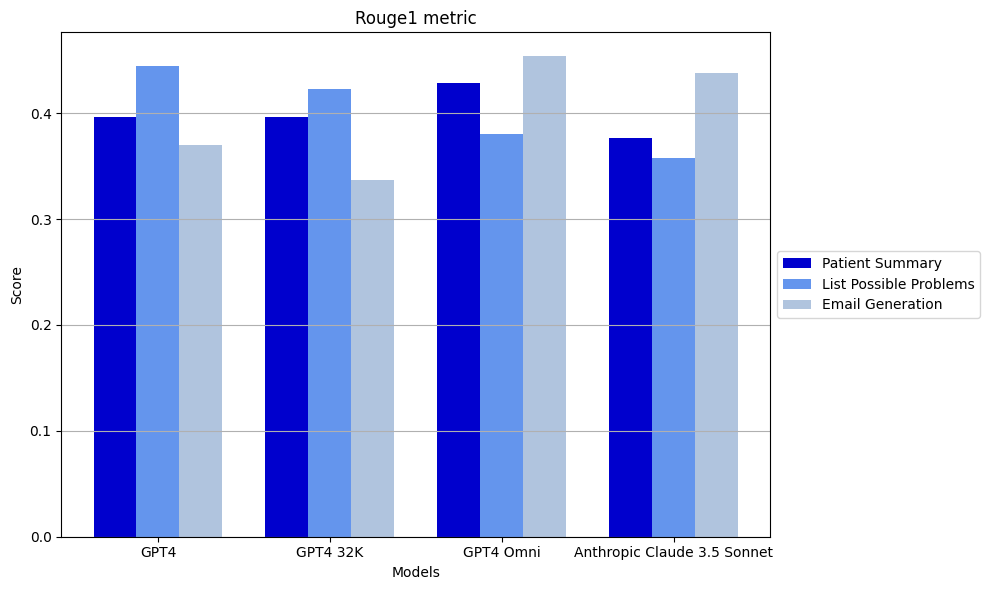

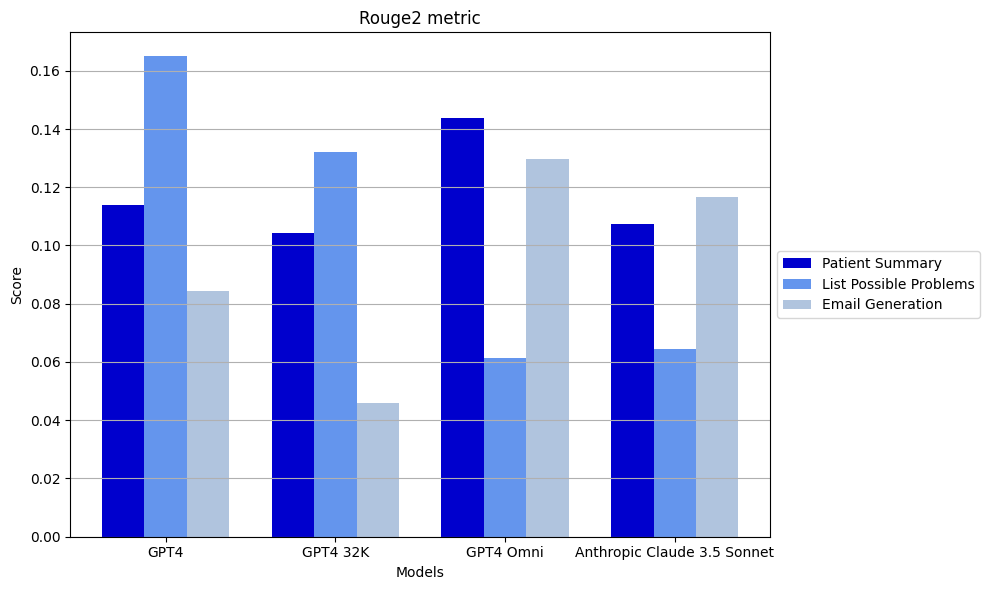

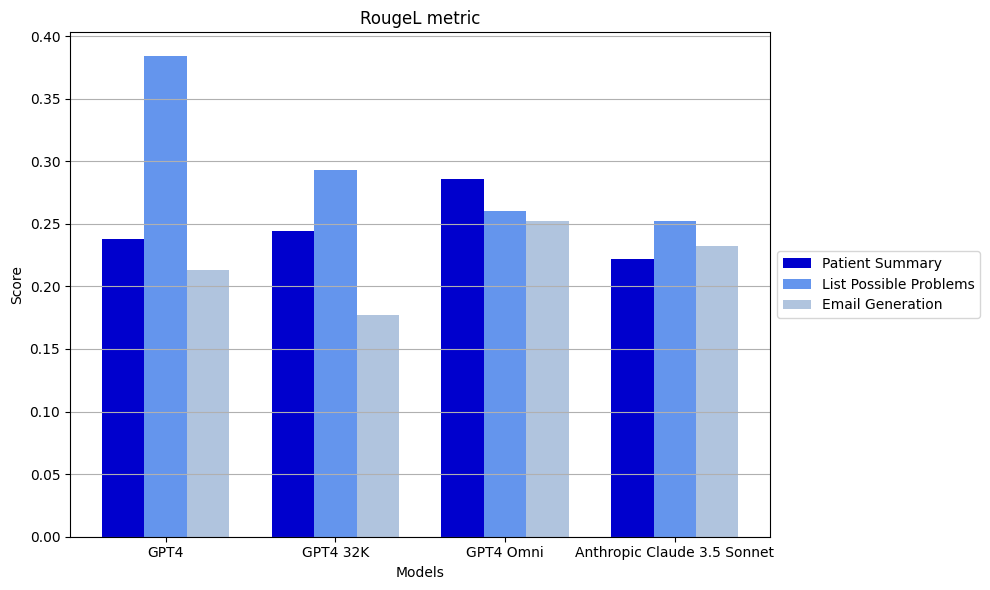

In [23]:
# rouge

# Definizione delle etichette per le metriche
metric_labels = ["Rouge1", "Rouge2", "RougeL"]
num_actions = len(Rmodel_action)  # Numero di azioni

# Configura la larghezza delle barre e l'intervallo per posizionare le barre affiancate
bar_width = 0.25
x = np.arange(len(Rmodel_action.columns))  # Posizioni dei modelli sull'asse x

colorlist = ["mediumblue", "cornflowerblue", "lightsteelblue"]

# Ciclo per ciascuna metrica
for i, metric in enumerate(metric_labels):
    
    plt.figure(figsize=(10, 6))  # Crea una nuova figura per ogni metrica
    
    # Ciclo per ciascuna azione (es. 'Patient Summary', 'List Possible Problems', 'Email Generation')
    for j, (action, name) in enumerate(zip(range(num_actions), ['Patient Summary', 'List Possible Problems', 'Email Generation'])):
        
        # Estrai i valori alla posizione `i` per ciascun modello e l'azione corrente
        values = [Rmodel_action[model][action][i] for model in Rmodel_action.columns]
        
        # Creazione delle barre affiancate
        plt.bar(x + j * bar_width, values, width=bar_width, label=name, color=colorlist[action])
    
    # Configura titolo, assi e legenda
    plt.title(f'{metric} metric')
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.xticks(x + bar_width, Rmodel_action.columns)  # Posizionamento dell'etichetta del modello in posizione centrale sotto i gruppi di barre
    plt.grid(True, axis='y')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()  # Ottimizza il layout per evitare sovrapposizioni
    plt.show()

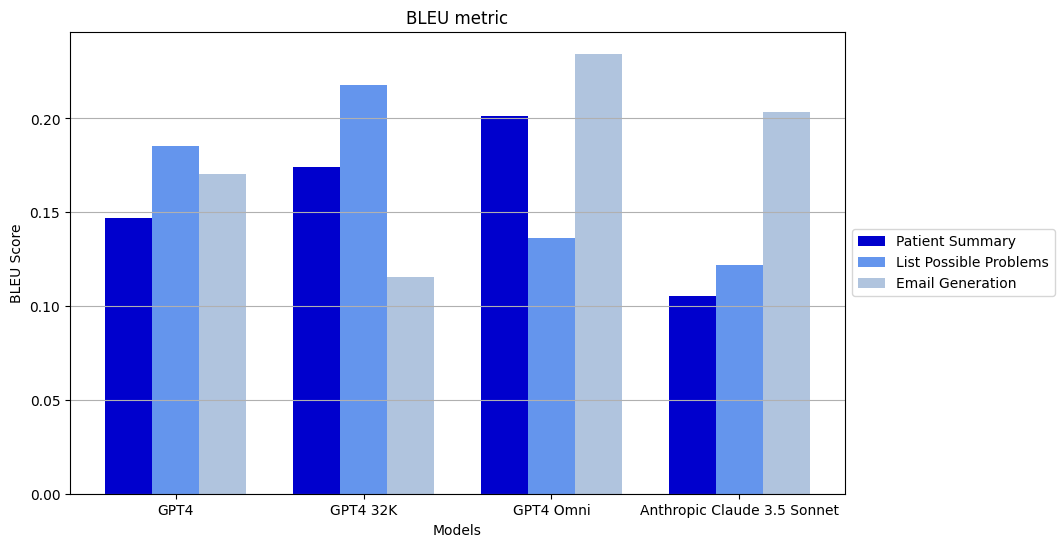

In [24]:
#bleu
# Lista dei nomi dei task
task_names = ['Patient Summary', 'List Possible Problems', 'Email Generation']
models = outputs_df.columns[:4]  # I primi 4 modelli

# Configurazione dell'istogramma
x = np.arange(len(models))  # Numero di modelli per posizioni sull'asse x
width = 0.25  # Larghezza delle barre

fig, ax = plt.subplots(figsize=(10, 6))

# Crea le barre per ciascun task
for i, (action, name) in enumerate(zip(range(len(task_names)), task_names)):
    values = BLmodel_action.iloc[action].values  # Estrae i valori per ciascun modello
    ax.bar(x + i * width, values, width, label=name, color=colorlist[action])

# Configura gli assi e le etichette
ax.set_xlabel("Models")
ax.set_ylabel("BLEU Score")
ax.set_title("BLEU metric")
ax.set_xticks(x + width)
ax.set_xticklabels(models)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, axis='y')
plt.show()

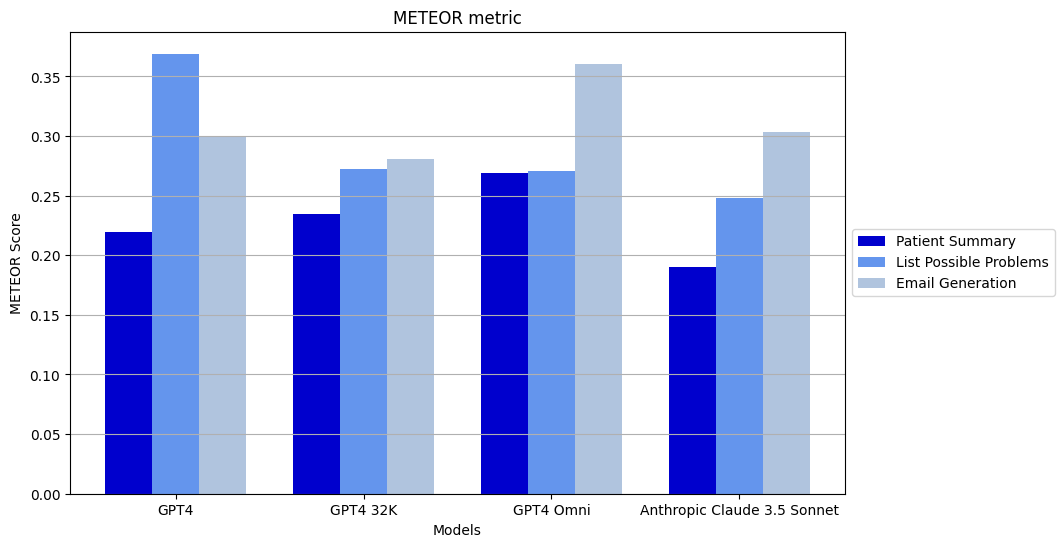

In [25]:
# METEOR

x = np.arange(len(models))  # Posizioni sull'asse x per ciascun modello
width = 0.25  # Larghezza delle barre

fig, ax = plt.subplots(figsize=(10, 6))

# Crea le barre per ciascun task
for i, (action, name) in enumerate(zip(range(len(task_names)), task_names)):
    values = Mmodel_action.iloc[action].values  # Estrae i valori per ciascun modello
    ax.bar(x + i * width, values, width, label=name, color=colorlist[action])

# Configura gli assi e le etichette
ax.set_xlabel("Models")
ax.set_ylabel("METEOR Score")
ax.set_title("METEOR metric")
ax.set_xticks(x + width)
ax.set_xticklabels(models)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, axis='y')
plt.show()

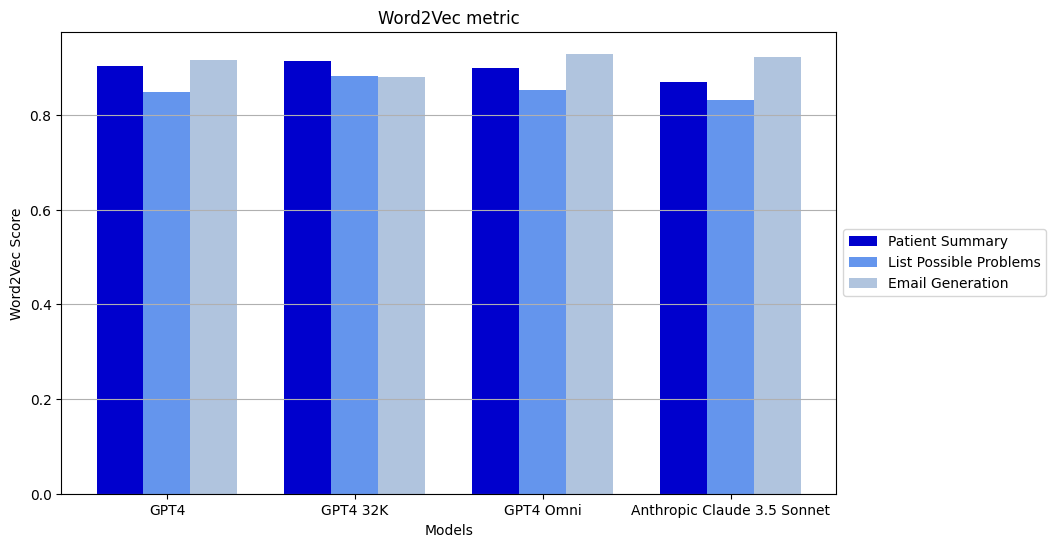

In [26]:
# word2vec
# Configura i dati per l'istogramma
x = np.arange(len(models))  # Posizioni sull'asse x per ciascun modello
width = 0.25  # Larghezza delle barre

fig, ax = plt.subplots(figsize=(10, 6))

# Crea le barre per ciascun task
for i, (action, name) in enumerate(zip(range(len(task_names)), task_names)):
    values = Wmodel_action.iloc[action].values  # Estrai i valori per ciascun modello
    ax.bar(x + i * width, values, width, label=name, color=colorlist[action])

# Configura gli assi e le etichette
ax.set_xlabel("Models")
ax.set_ylabel("Word2Vec Score")
ax.set_title("Word2Vec metric")
ax.set_xticks(x + width)
ax.set_xticklabels(models)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, axis='y')
plt.show()

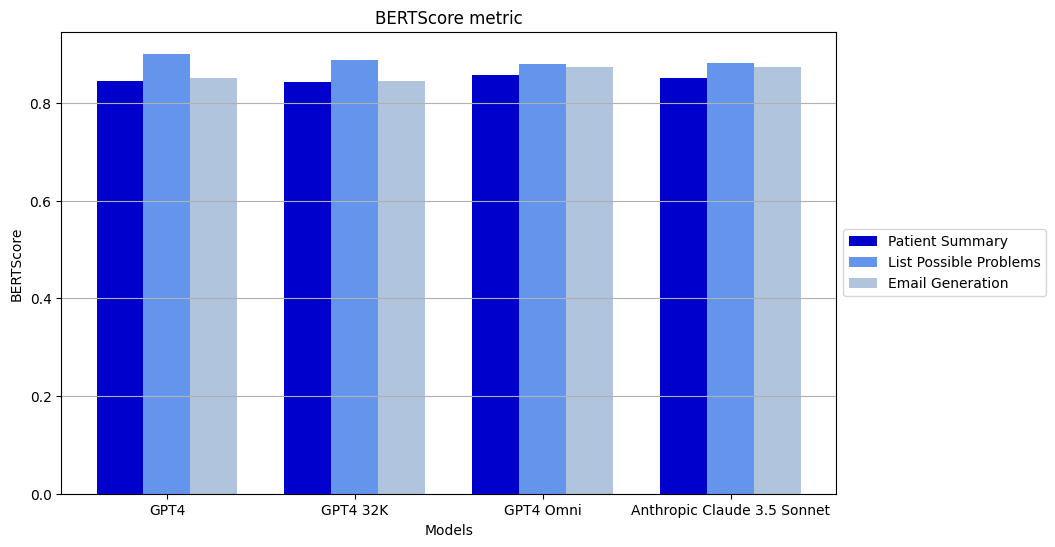

In [27]:
# BERT score
# Configura i dati per l'istogramma
x = np.arange(len(models))  # Posizioni sull'asse x per ciascun modello
width = 0.25  # Larghezza delle barre

fig, ax = plt.subplots(figsize=(10, 6))

# Crea le barre per ciascun task
for i, (action, name) in enumerate(zip(range(len(task_names)), task_names)):
    values = Bmodel_action.iloc[action].values  # Estrai i valori per ciascun modello
    ax.bar(x + i * width, values, width, label=name, color=colorlist[action])

# Configura gli assi e le etichette
ax.set_xlabel("Models")
ax.set_ylabel("BERTScore")
ax.set_title("BERTScore metric")
ax.set_xticks(x + width)
ax.set_xticklabels(models)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, axis='y')
plt.show()

### G-Eval vs Human Feedback

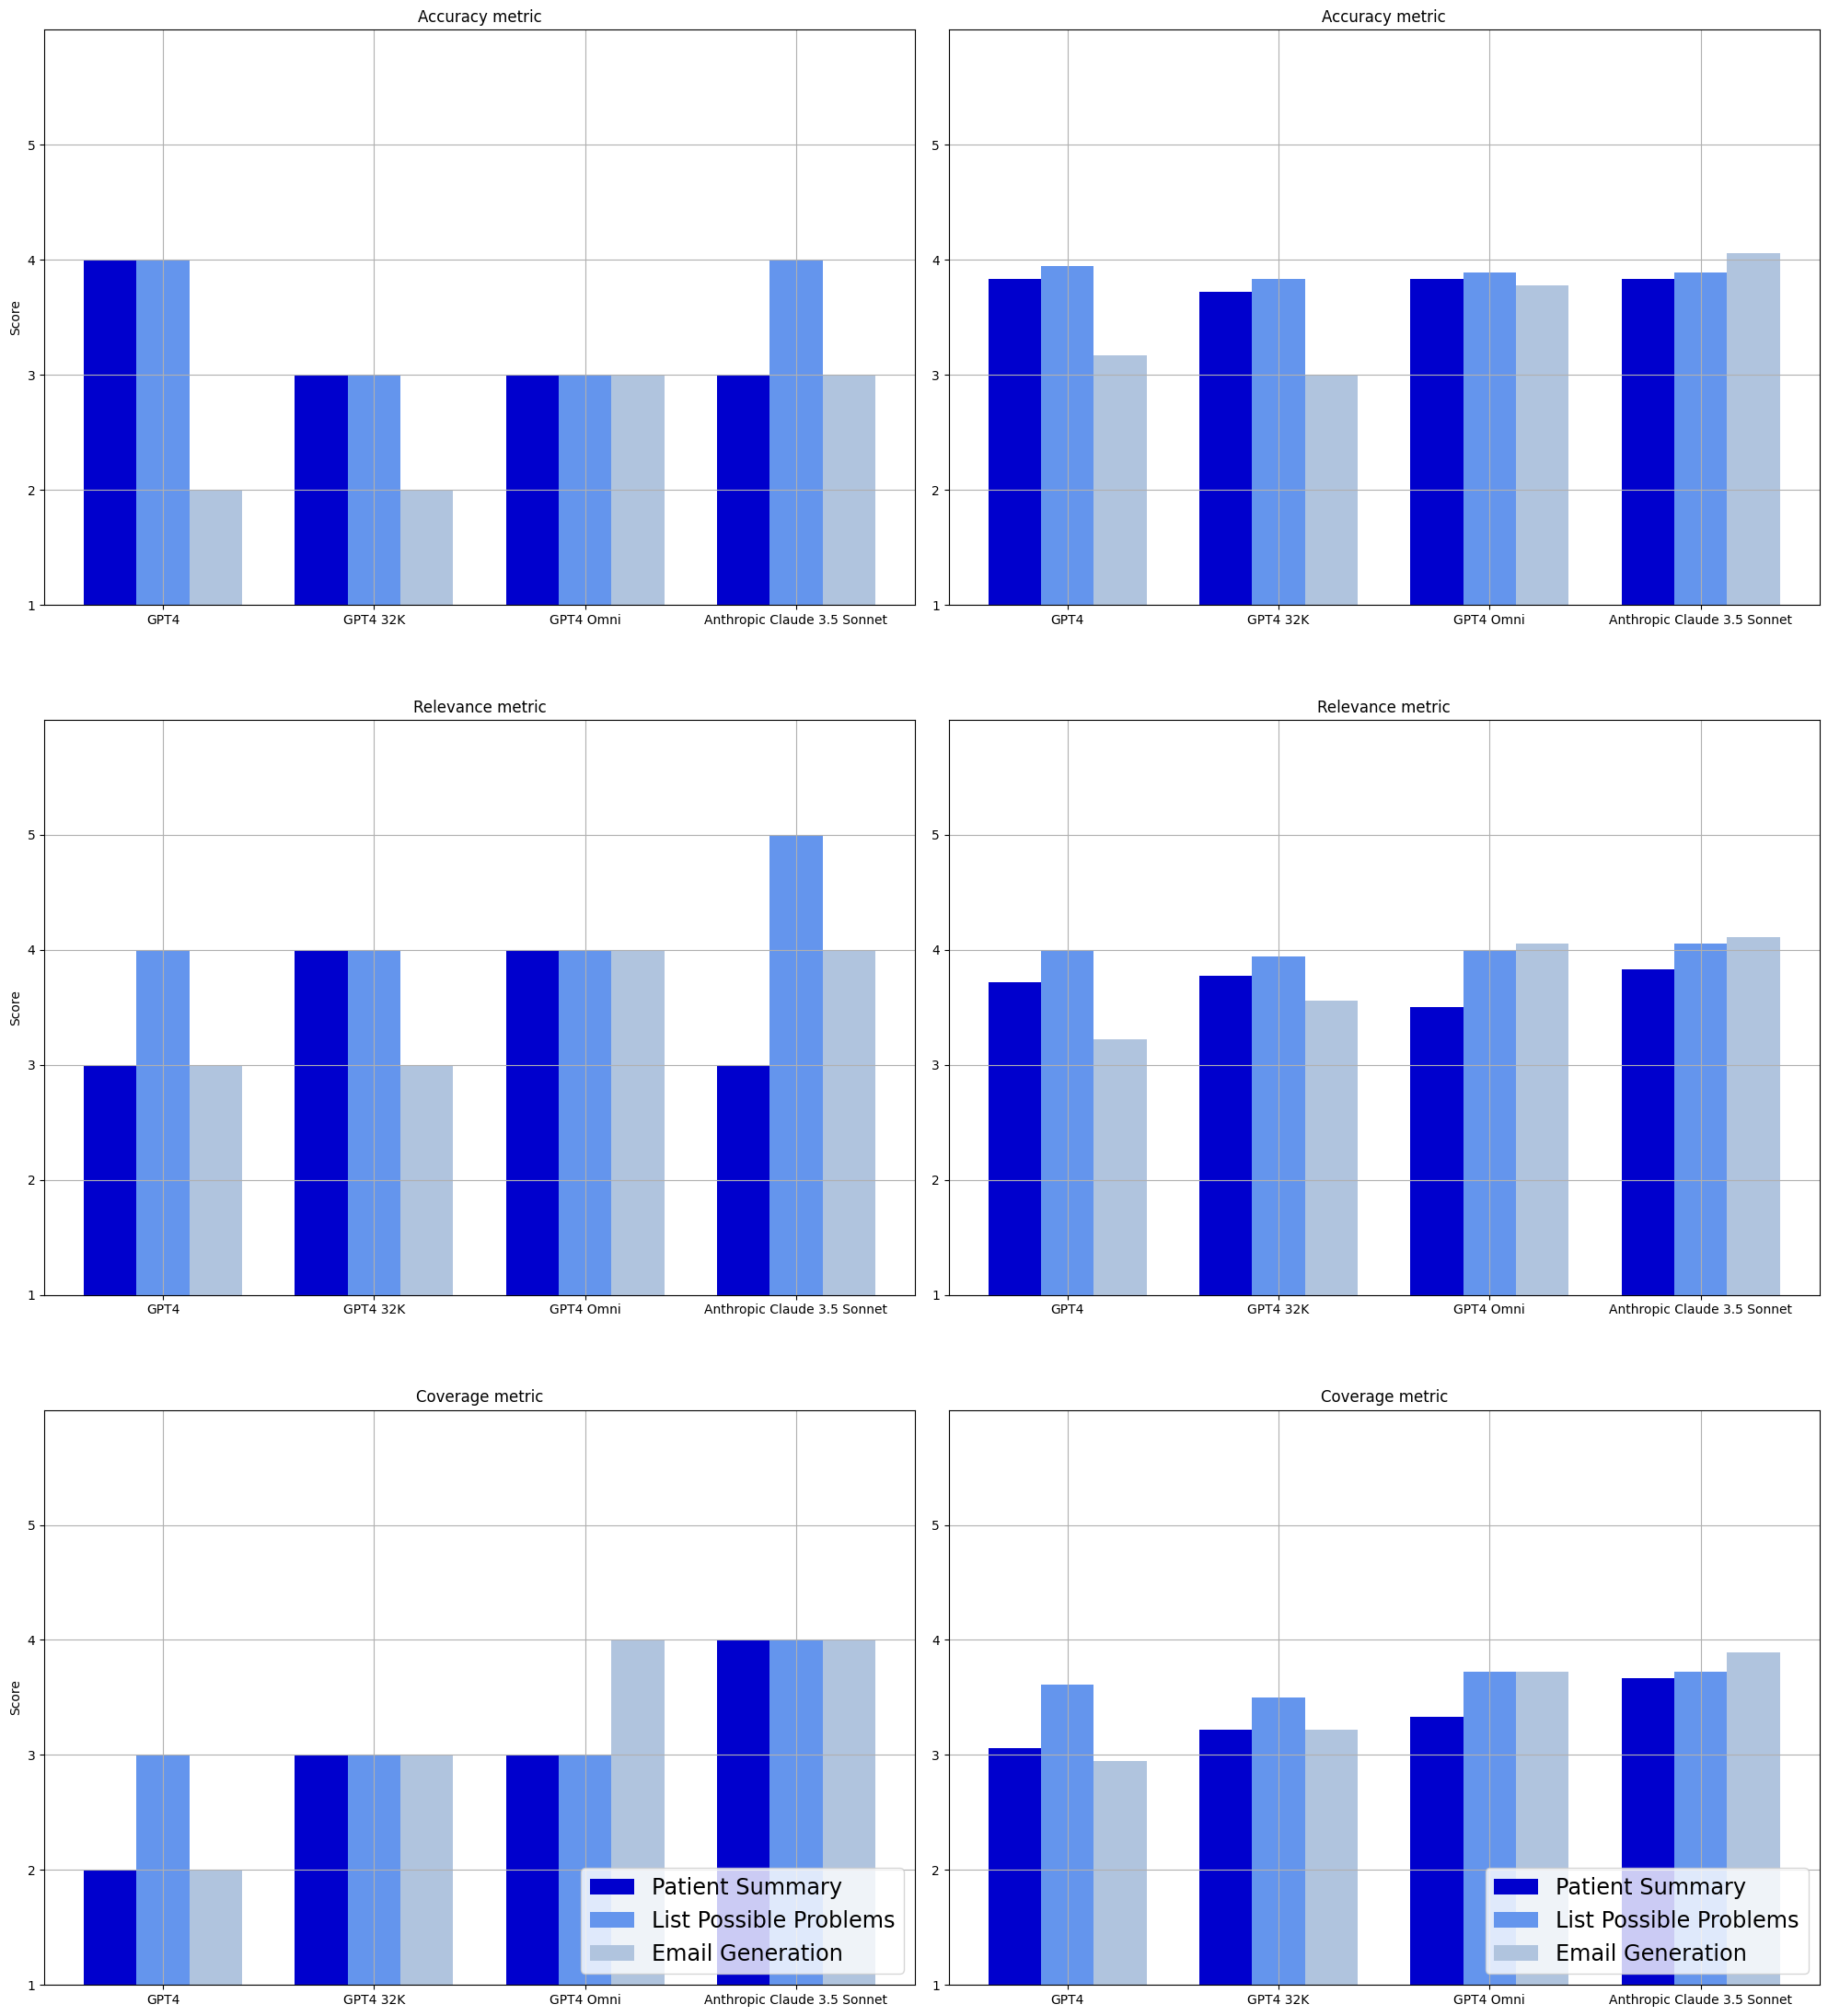

In [28]:

#comparison

# Impostazione della figura con 3 righe e 2 colonne per i subplot
fig, axs = plt.subplots(3, 2, figsize=(20,22))
#fig.set_size_inches(20,22)
# Parametri per le barre affiancate
bar_width = 0.25
x = np.arange(len(Gmodel_action.columns))

# Loop per ogni metrica
for metric in range(3):
    gx = axs[metric, 0]  # primo subplot per Gvalues
    hx = axs[metric, 1]  # secondo subplot per Hvalues
    
    # Loop per ogni tipo di task
    for i, label in enumerate(['Patient Summary', 'List Possible Problems', 'Email Generation']):
        Gvalues = [Gmodel_action[model][i][metric] for model in Gmodel_action.columns]
        Hvalues = [human_eval_compact[model][i][metric] for model in Gmodel_action.columns]
        
        # Creazione delle barre affiancate per gx e hx
        gx.bar(x + i * bar_width, Gvalues, width=bar_width, label=label, color=colorlist[i])
        hx.bar(x + i * bar_width, Hvalues, width=bar_width, label=label, color=colorlist[i])
    
    # Impostazione dei titoli e delle etichette per ogni subplot
    gx.set_title(f'{Gmetric_labels[metric]} metric')
    hx.set_title(f'{Gmetric_labels[metric]} metric')
    gx.set_ylabel('Score')
    gx.set_ylim((1, 6))
    hx.set_ylim((1, 6))
    gx.set_yticks(range(1, 6, 1))
    hx.set_yticks(range(1, 6, 1))
    
    # Etichette per i modelli sull'asse x
    gx.set_xticks(x + bar_width)
    gx.set_xticklabels(Gmodel_action.columns)
    hx.set_xticks(x + bar_width)
    hx.set_xticklabels(Gmodel_action.columns)
    
    # Aggiungi griglia e legenda
    gx.grid(True)
    hx.grid(True)
    if metric == 2:  # Aggiungi legenda nell'ultima riga per evitare ripetizioni
        gx.legend(loc='lower right', fontsize='xx-large')
        hx.legend(loc='lower right', fontsize='xx-large')

# Migliora il layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.show()

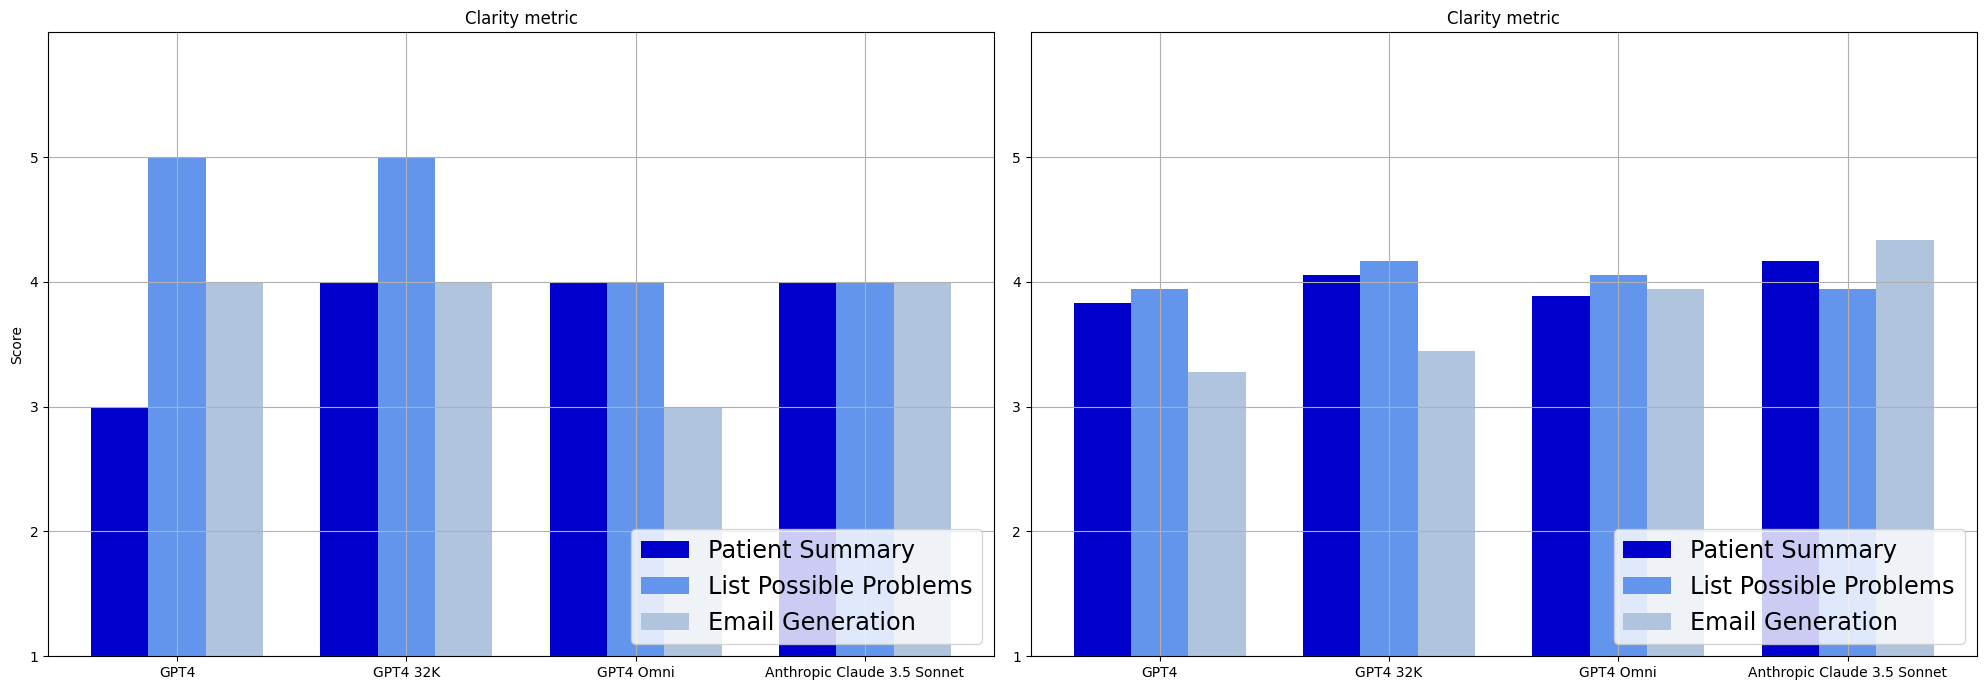

In [33]:
#comparison cont

# Impostazione delle figure per i plot
fig, axs = plt.subplots(1, 2, figsize=(20, 7))  # 1 riga, 2 colonne per i subplot

gx = axs[0]  # primo subplot per Gvalues
hx = axs[1]  # secondo subplot per Hvalues

# Parametri per impostare le barre affiancate
bar_width = 0.25  # larghezza delle barre
x = np.arange(len(Gmodel_action.columns))  # posizione delle colonne dei modelli sull'asse x

# Plot per ogni action label
for i, label in enumerate(['Patient Summary', 'List Possible Problems', 'Email Generation']):
    Gvalues = [Gmodel_action[model][i][3] for model in Gmodel_action.columns]
    Hvalues = [human_eval_compact[model][i][3] for model in Gmodel_action.columns]
    
    # Creazione delle barre in gx e hx con offset per affiancare le categorie
    gx.bar(x + i * bar_width, Gvalues, width=bar_width, label=label, color=colorlist[i])
    hx.bar(x + i * bar_width, Hvalues, width=bar_width, label=label, color=colorlist[i])

# Impostazione dei titoli, delle etichette e del layout
gx.set_title(f'{Gmetric_labels[3]} metric')
hx.set_title(f'{Gmetric_labels[3]} metric')

# Etichette asse y e intervalli
gx.set_ylabel('Score')
gx.set_ylim((1, 6))
hx.set_ylim((1, 6))
gx.set_yticks(range(1, 6, 1))
hx.set_yticks(range(1, 6, 1))

# Etichette asse x con nomi dei modelli
gx.set_xticks(x + bar_width)  # Allineamento per le barre affiancate
gx.set_xticklabels(Gmodel_action.columns)
hx.set_xticks(x + bar_width)
hx.set_xticklabels(Gmodel_action.columns)

# Aggiungi griglia e legenda
gx.grid(True)
hx.grid(True)
gx.legend(loc='lower right', fontsize='xx-large')
hx.legend(loc='lower right', fontsize='xx-large')

# Visualizzazione della figura
plt.tight_layout()
plt.show()